# Risk forecasting DNN model

### Hyperparameters

In [1]:
# options
TIME_PROFILING = True
MEMORY_PROFILING = False

BASELINE = True
LOW_BIT_TRAINING = True
PROGRESSIVE_TRAINING = True
ACTIVE_LEARNING = True

# data params
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.8

# general model params 
EPOCHS = 100
BATCH_SIZE = 32
NODES_PER_LAYER = 16

# low-bit training
MIXED_PRECISION = 'mixed_float16'
HIGH_PRECISION = 'float32'

# progressive training params
PRETRAINING_EPOCHS = 20
TUNING_EPOCHS = 30

# active learning params
AL_ITERATIONS = 100
AL_SAMPLE = 100
AL_EPOCHS = 1

### Imports

In [28]:
# if running through colab, install external packages
!pip3 install -r ./drive/MyDrive/UCL/Thesis/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from datetime import datetime
from time import time
from scipy.stats import norm

# financial imports
import yfinance as yf

# tensorflow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

# profiling imports
from line_profiler import LineProfiler

In [4]:
# check if connected to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8655a7f1-4c09-59b2-25cf-179db975f356)


### Data curation and manipulation

In [5]:
# formula for historical volatility
def compute_volatility(window):
    _v = window - np.mean(window)
    _v = np.square(_v)
    _v = np.sum(_v)
    _v = _v / LOOKBACK_WINDOW
    _v = np.sqrt(_v)

    return _v

In [6]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(start='1950-01-04', end='2022-08-02', interval=SERIES_INTERVAL)

close = sp500_history.Close.loc[sp500_history.Close != 0]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = [compute_volatility(log_returns[i: i + LOOKBACK_WINDOW]) for i in range(log_returns.shape[0] - LOOKBACK_WINDOW)]

# gather other variables
_open = sp500_history.Open[1:]
_high = sp500_history.High[1:]
_low = sp500_history.Low[1:]
_volume = sp500_history.Volume[1:]

close = close[1:]
volatility = pd.Series(volatility, index=log_returns[LOOKBACK_WINDOW:].keys())

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'close': (close - close.min()) / close.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'returns': log_returns / np.abs(log_returns).max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# fill nan values in volatility column (these won't be used)
X.volatility = X.volatility.fillna(0)

X

,open,close,high,low,volume,returns,volatility
Date,,,,,,,
1950-01-05,0.003524,0.000054,0.000054,0.000054,0.000163,0.020684,0.000000
1950-01-06,0.003534,0.000065,0.000064,0.000065,0.000116,0.012878,0.000000
1950-01-09,0.003555,0.000085,0.000085,0.000086,0.000161,0.025642,0.000000
1950-01-10,0.003545,0.000075,0.000075,0.000075,0.000129,-0.012802,0.000000
1950-01-11,0.003557,0.000088,0.000087,0.000088,0.000170,0.015358,0.000000
...,...,...,...,...,...,...,...
2022-07-26,0.822814,0.813996,0.816945,0.814652,0.269089,-0.050701,0.126826
2022-07-27,0.822442,0.835378,0.834864,0.823165,0.312798,0.112753,0.129777
2022-07-28,0.837990,0.845556,0.843038,0.831855,0.338870,0.052666,0.147466


In [7]:
# construct path to directory in which plots and profiling metrics are saved
results_path = './drive/MyDrive/UCL/Thesis/results/'

if not os.path.isdir(results_path):
    now = datetime.now()
    now = now.strftime("%d-%m-%Y_%H-%M-%S")
    results_path = f'./results_{now}/'
    os.mkdir(results_path)

print(f"Results will be saved to the directory: {results_path}")

Results will be saved to the directory: ./drive/MyDrive/UCL/Thesis/results/


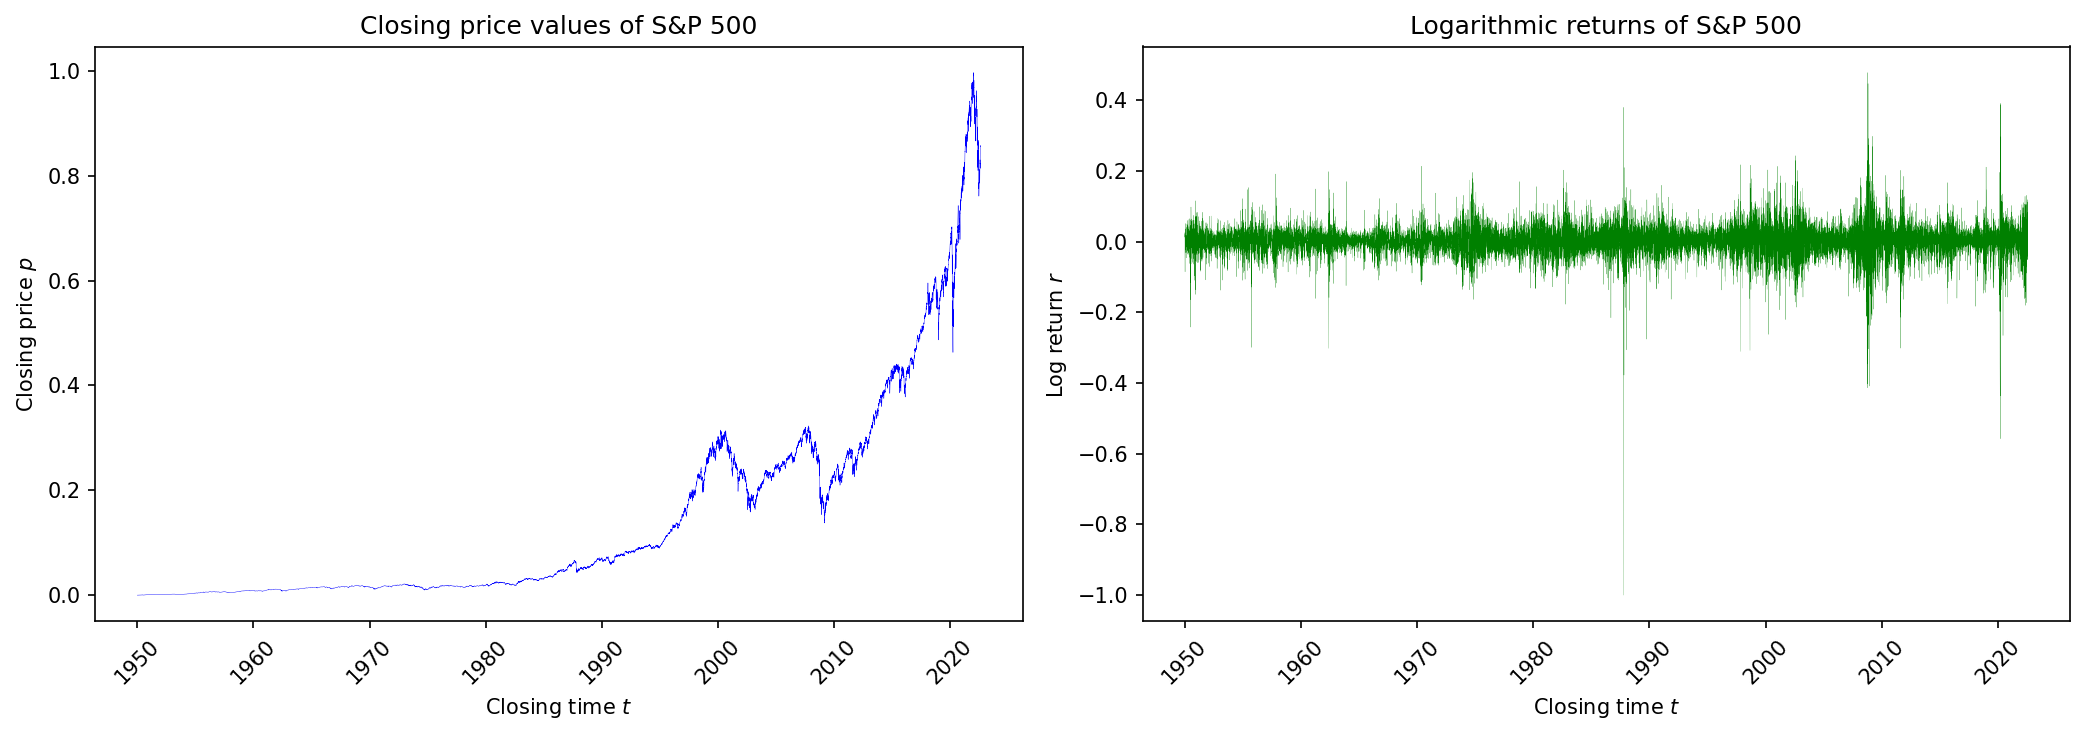

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
fig.savefig(results_path + "dataset.png")

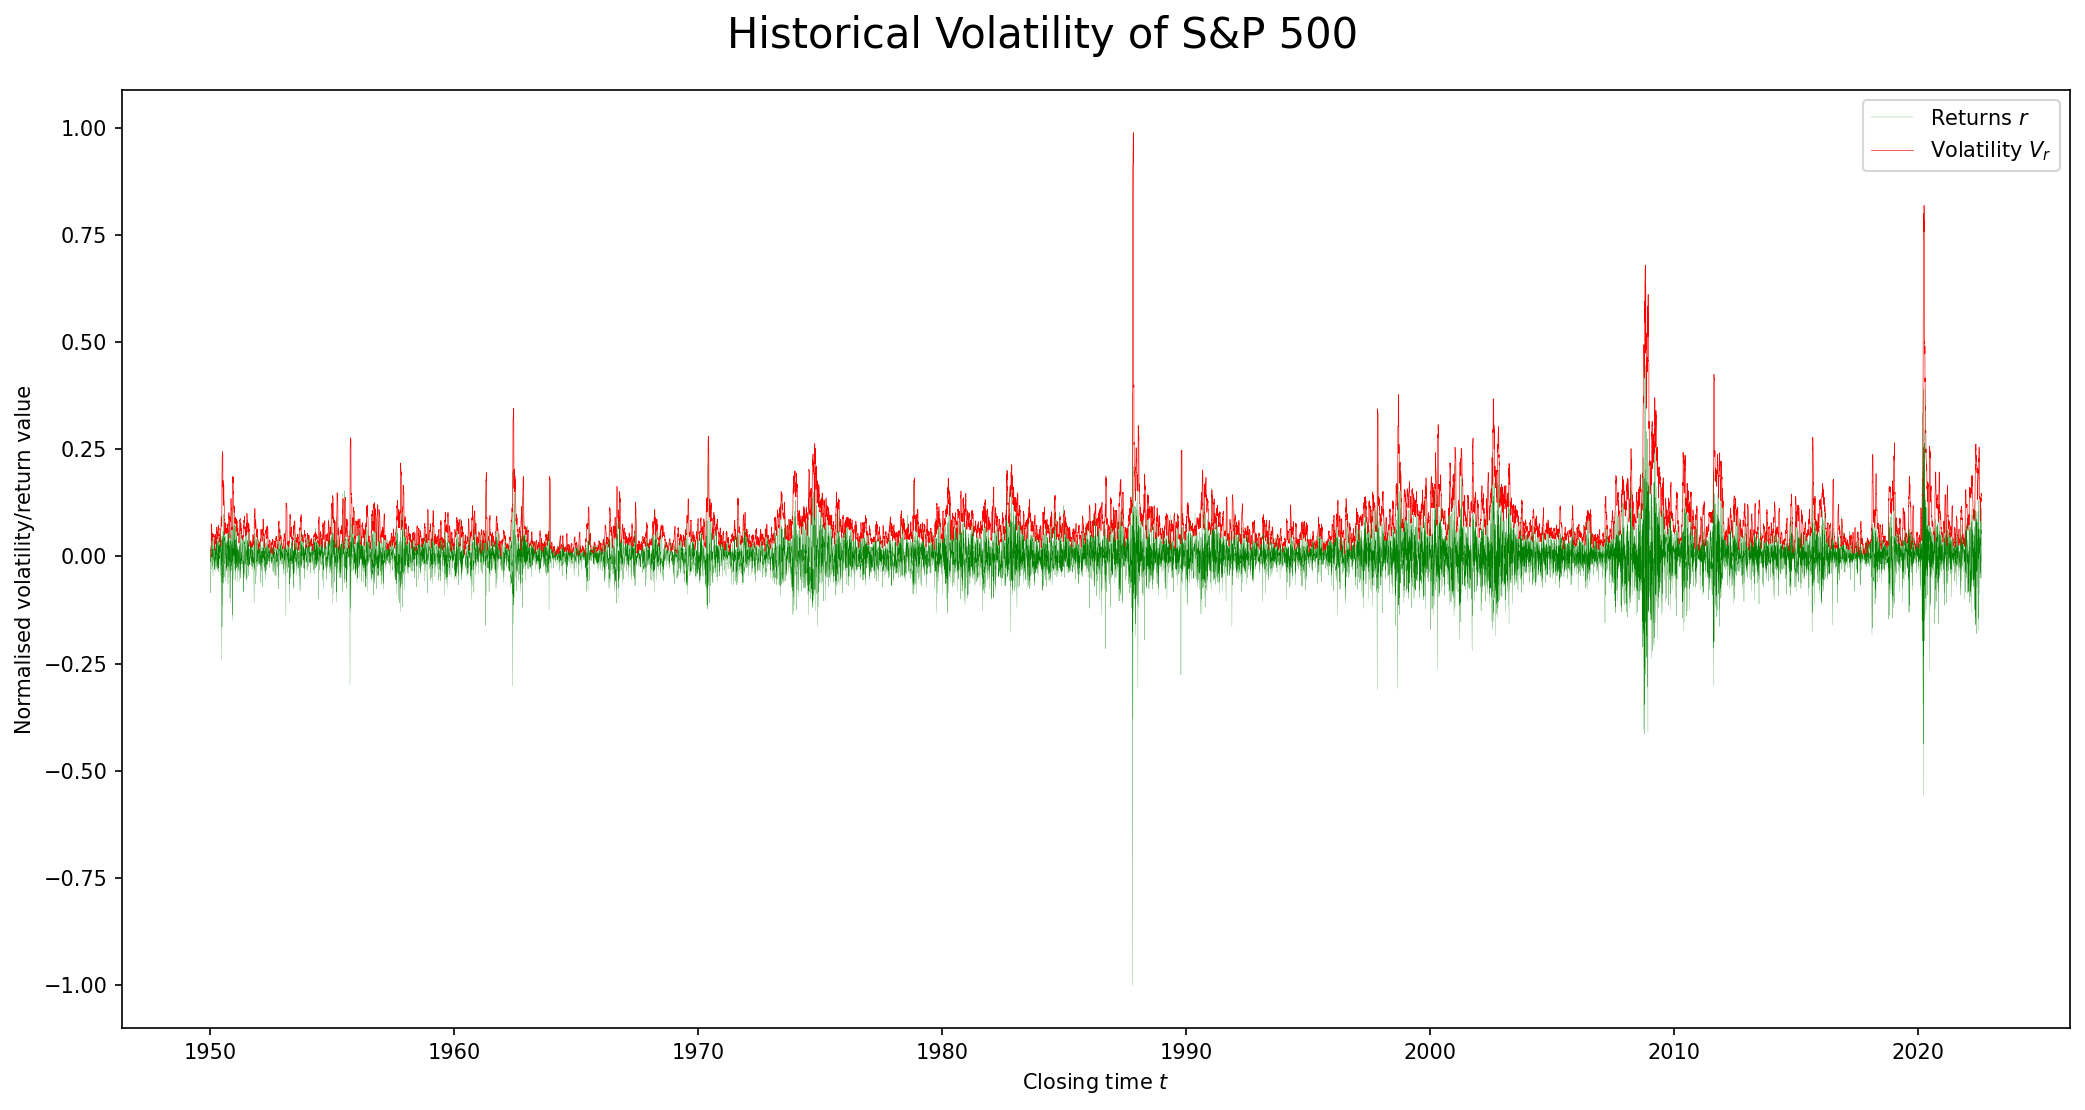

In [9]:
# plot computed volatility
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.suptitle("Historical Volatility of S&P 500", y=1.05, fontsize=20)

ax.plot(X.returns, linewidth=0.1, color='g', label='Returns $r$')
ax.plot(X.volatility, linewidth=0.3, color='r', label='Volatility $V_r$')
ax.set(xlabel=r'Closing time $t$', ylabel='Normalised volatility/return value')
ax.legend()

plt.tight_layout()
plt.show()
fig.savefig(results_path + "volatility.png")

In [10]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW):
    # compute volatility 
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + 1])

# convert X, y to numpy arrays (and scale volatility)
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

80% training data, 20% testing data
Train: (14600, 10, 7) (14600, 1) 
Test:  (3651, 10, 7) (3651, 1)


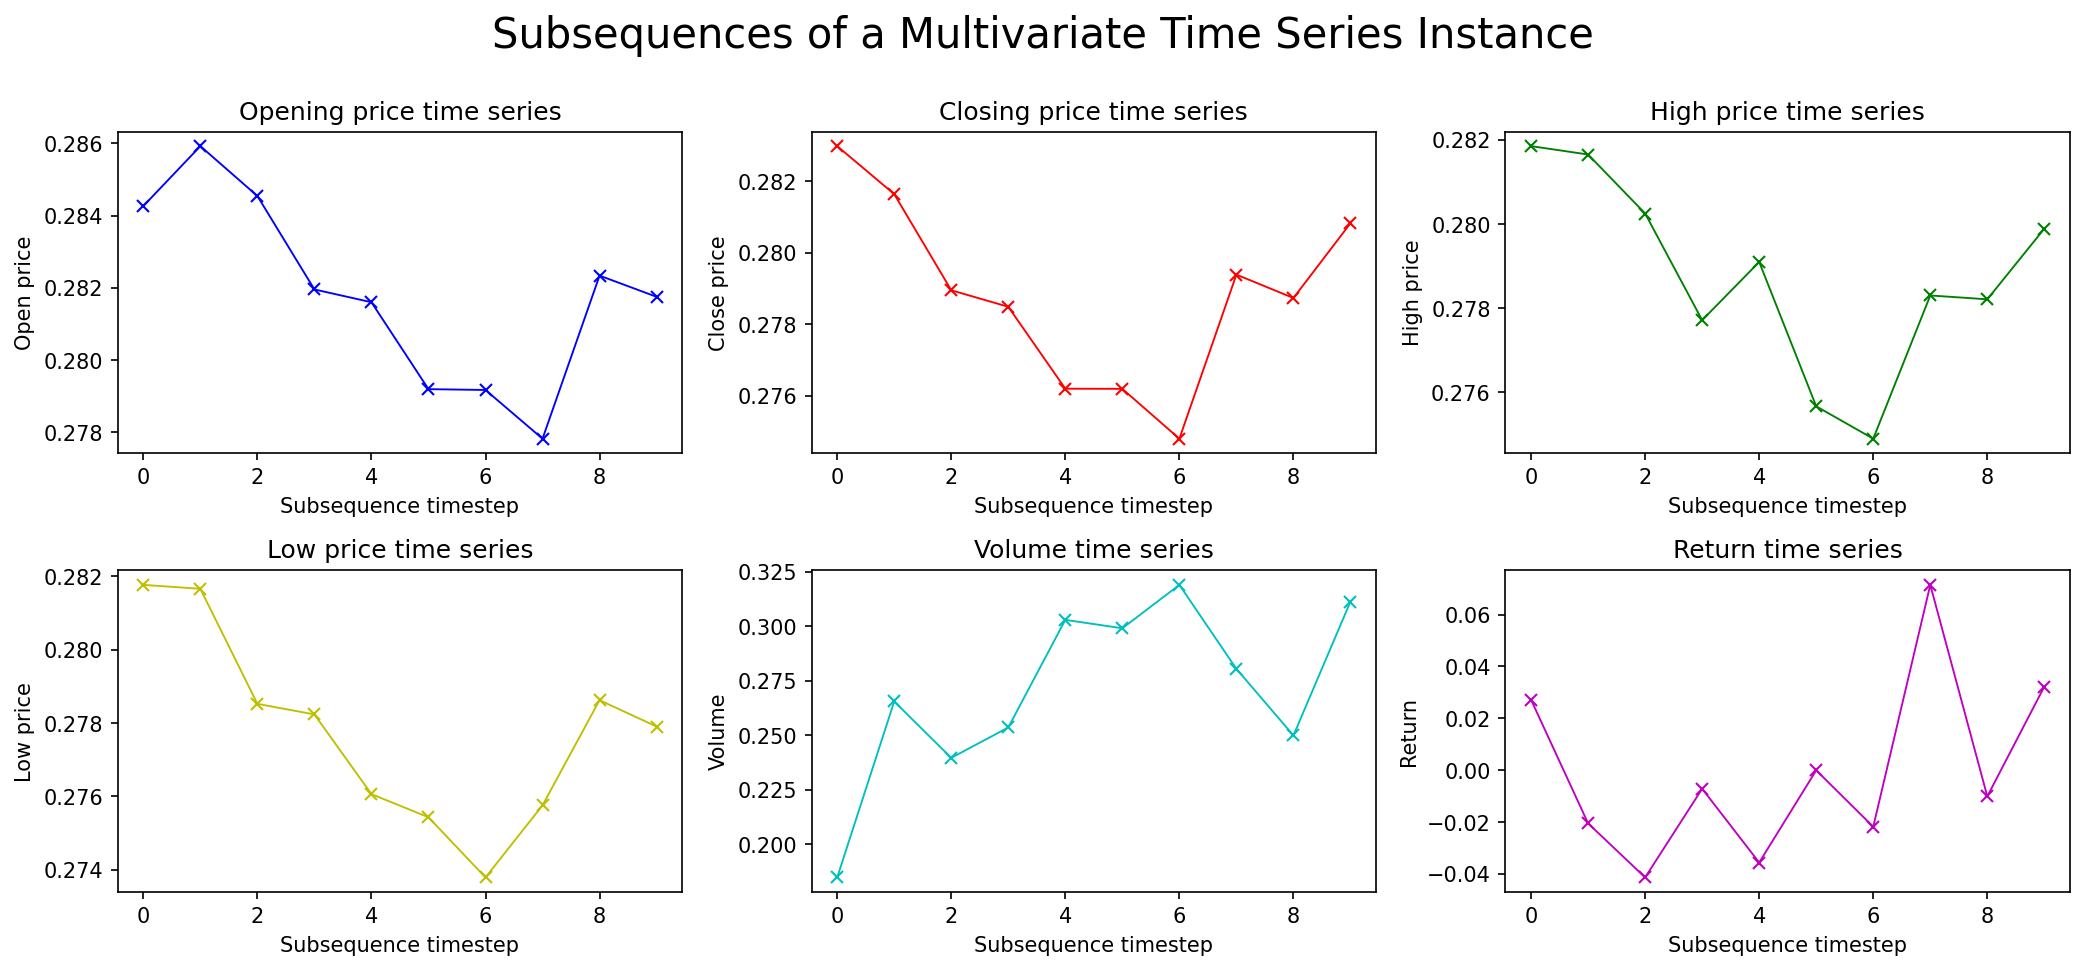

In [11]:
# examples of individual variable time series instance
np.random.seed(123)
random_index = np.random.randint(0, y_data.shape[0])
time_series = X_data[random_index]
label = y_data[random_index][0]

fig, ax = plt.subplots(2, 3, figsize=(14, 6), dpi=150)
fig.suptitle("Subsequences of a Multivariate Time Series Instance", y=1.07, fontsize=20)

ax[0, 0].plot(time_series[:, 0], color='b', marker='x', linewidth=0.9)
ax[0, 0].set(title=f'Opening price time series', xlabel=r'Subsequence timestep', ylabel=r'Open price')

ax[0, 1].plot(time_series[:, 1], color='r', marker='x', linewidth=0.9)
ax[0, 1].set(title=f'Closing price time series', xlabel=r'Subsequence timestep', ylabel=r'Close price')

ax[0, 2].plot(time_series[:, 2], color='g', marker='x', linewidth=0.9)
ax[0, 2].set(title=f'High price time series', xlabel=r'Subsequence timestep', ylabel=r'High price')

ax[1, 0].plot(time_series[:, 3], color='y', marker='x', linewidth=0.9)
ax[1, 0].set(title=f'Low price time series', xlabel=r'Subsequence timestep', ylabel=r'Low price')

ax[1, 1].plot(time_series[:, 4], color='c', marker='x', linewidth=0.9)
ax[1, 1].set(title=f'Volume time series', xlabel=r'Subsequence timestep', ylabel=r'Volume')

ax[1, 2].plot(time_series[:, 5], color='m', marker='x', linewidth=0.9)
ax[1, 2].set(title=f'Return time series', xlabel=r'Subsequence timestep', ylabel=r'Return')

plt.tight_layout()
plt.show()
fig.savefig(results_path + "subsequences.png")

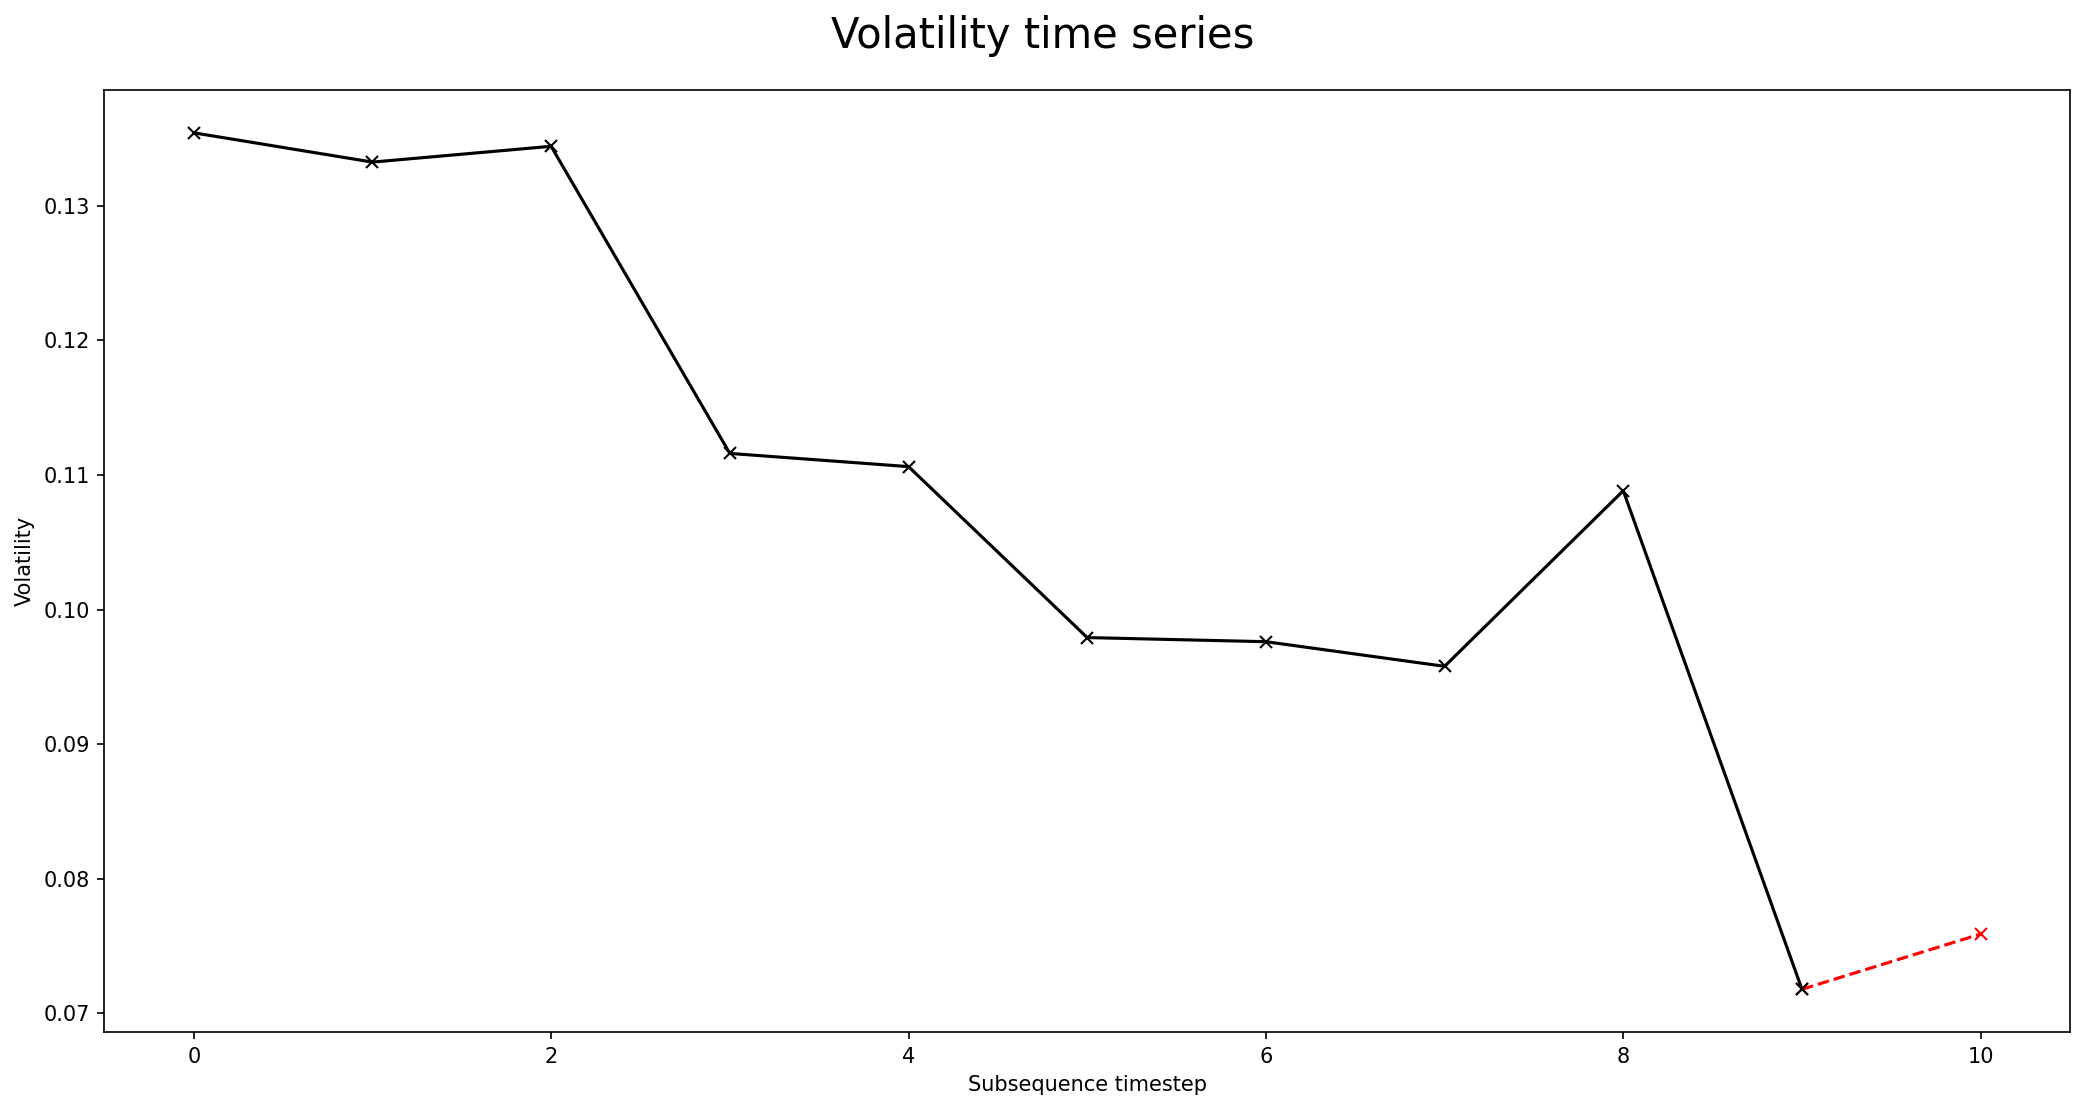

In [12]:
# example of volatility time series instance
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)
fig.suptitle("Volatility time series", y=1.05, fontsize=20)

ax.plot([9, 10], [time_series[:, 6][-1], label], color='r', marker='x', linestyle='dashed')
ax.plot(time_series[:, 6], color='k', marker='x')
ax.set(xlabel=r'Subsequence timestep', ylabel=r'Volatility')

plt.tight_layout()
plt.show()
fig.savefig(results_path + "volatility-subsequence.png")

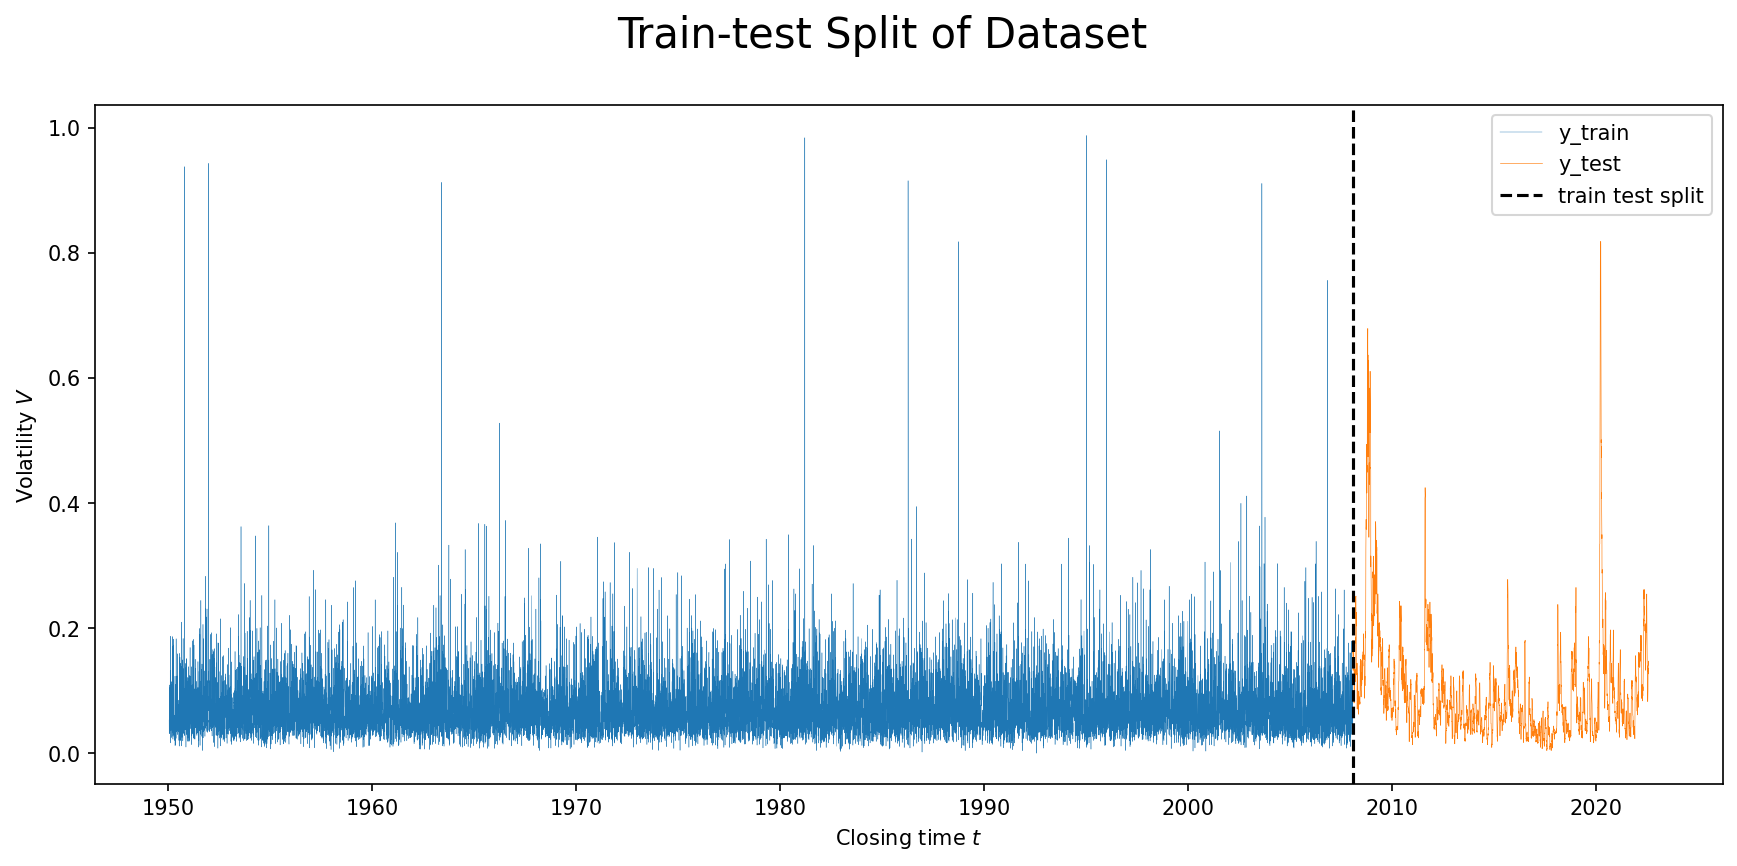

In [13]:
# plot the train-test split data
fig, ax = plt.subplots(figsize=(14, 6), dpi=150)
fig.suptitle("Train-test Split of Dataset", fontsize=20)

y_train_plot = y_train.flatten()
y_train_plot = pd.Series(y_train_plot, index=X.volatility[LOOKBACK_WINDOW: LOOKBACK_WINDOW + split].keys())

y_test_plot = y_test.flatten()
y_test_plot = pd.Series(y_test_plot, index=X.volatility[LOOKBACK_WINDOW + split:].keys())

ax.plot(y_train_plot, label='y_train', linewidth=0.2)
ax.plot(y_test_plot, label='y_test', linewidth=0.3)
ax.axvline(y_test_plot.keys()[0], color='k', linestyle='--', label='train test split')
ax.set(xlabel=r'Closing time $t$', ylabel=r'Volatility $V$')
ax.legend()

plt.show()
fig.savefig(results_path + "traintest-split.png")

### Analysis Metrics

In [14]:
# metric functions
def compute_mae(y_true, y_hat):
    _ae = np.abs(np.subtract(y_true, y_hat))
    _mae = _ae.mean()

    return _mae


def compute_rmse(y_true, y_hat):
    _se = np.square(np.subtract(y_true, y_hat))
    _rmse = np.sqrt(_se.mean())

    return _rmse


def compute_mape(y_true, y_hat):
    _ape = np.abs((y_true - y_hat) / y_true)
    _mape = _ape.mean() * 100

    return _mape


history = {
    'baseline': None,
    'mixed-precision': None,
    'sup-progressive': None,
    'unsup-progressive': None,
    'active-learning': None
}

### Baseline comparison model

In [15]:
# ensure tensorflow is using high precision (i.e. not in low-bit training mode)
policy_hp = mixed_precision.Policy(HIGH_PRECISION)
mixed_precision.set_global_policy(policy_hp)

print(f'Compute dtype: {policy_hp.compute_dtype}')
print(f'Variable dtype: {policy_hp.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


In [16]:
# constructing the LSTM model architecture
def build_baseline_model(X):
     # build baseline model architecture
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, input_shape=(X.shape[1:]), activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    # compile baseline model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    return model


# baseline training algorithm
def baseline_training(model, X, y):
    # train and evaluate baseline model
    hist = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    history['baseline'] = hist.history

In [17]:
if BASELINE:
    # construct baseline model and show its architecture
    comp_model = build_baseline_model(X_train)
    comp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 16)            1536      
                                                                 
 lstm_1 (LSTM)               (None, 10, 16)            2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


In [18]:
if BASELINE:
    # train baseline model
    if TIME_PROFILING:
        # running line-by-line profiling over baseline training process
        baseline_profiler = LineProfiler()
        profile_function = baseline_profiler(baseline_training)
        profile_function(comp_model, X_train, y_train)
    else:
        baseline_training(comp_model, X_train, y_train)

Epoch 1/100
92/92 [==============================] - 12s 38ms/step - loss: 0.0280 - mse: 0.0020 - val_loss: 0.0207 - val_mse: 0.0012
Epoch 2/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0195 - mse: 0.0010 - val_loss: 0.0193 - val_mse: 0.0010
Epoch 3/100
92/92 [==============================] - 2s 19ms/step - loss: 0.0192 - mse: 9.3207e-04 - val_loss: 0.0192 - val_mse: 0.0010
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0180 - mse: 8.3770e-04 - val_loss: 0.0186 - val_mse: 9.0925e-04
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0175 - mse: 7.5285e-04 - val_loss: 0.0197 - val_mse: 8.7409e-04
Epoch 6/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0170 - mse: 6.5451e-04 - val_loss: 0.0163 - val_mse: 7.3601e-04
Epoch 7/100
92/92 [==============================] - 2s 19ms/step - loss: 0.0152 - mse: 5.1267e-04 - val_loss: 0.0145 - val_mse: 5.3943e-04
Epoch 8/100
92/92 [====================

In [25]:
if BASELINE and TIME_PROFILING:
    print(fr"Profiling the baseline model's training process (Time in microseconds):", end='\n\n')
    baseline_profiler.print_stats()

Profiling the baseline model's training process (Time in microseconds):

Timer unit: 1e-06 s

Total time: 196.118 s
File: <ipython-input-16-77774932d2ae>
Function: baseline_training at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def baseline_training(model, X, y):
    20                                               # train and evaluate baseline model
    21         1  196118259.0 196118259.0    100.0      hist = model.fit(X, y, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    22         1          5.0      5.0      0.0      history['baseline'] = hist.history



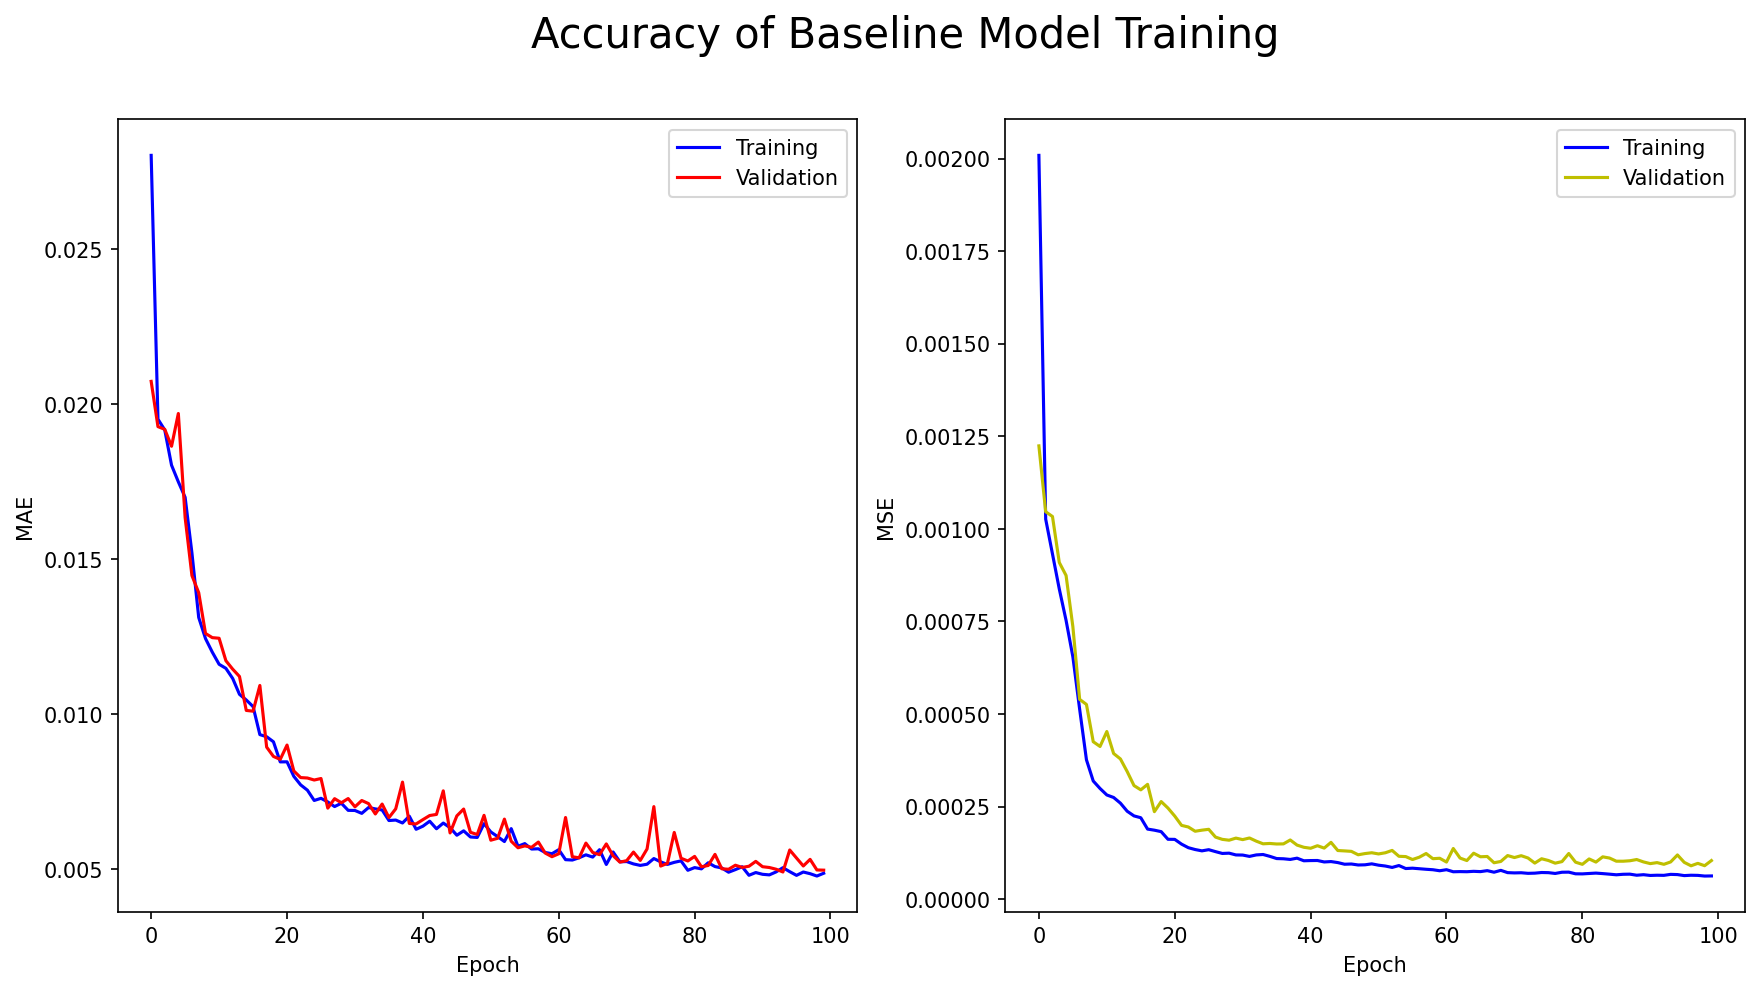

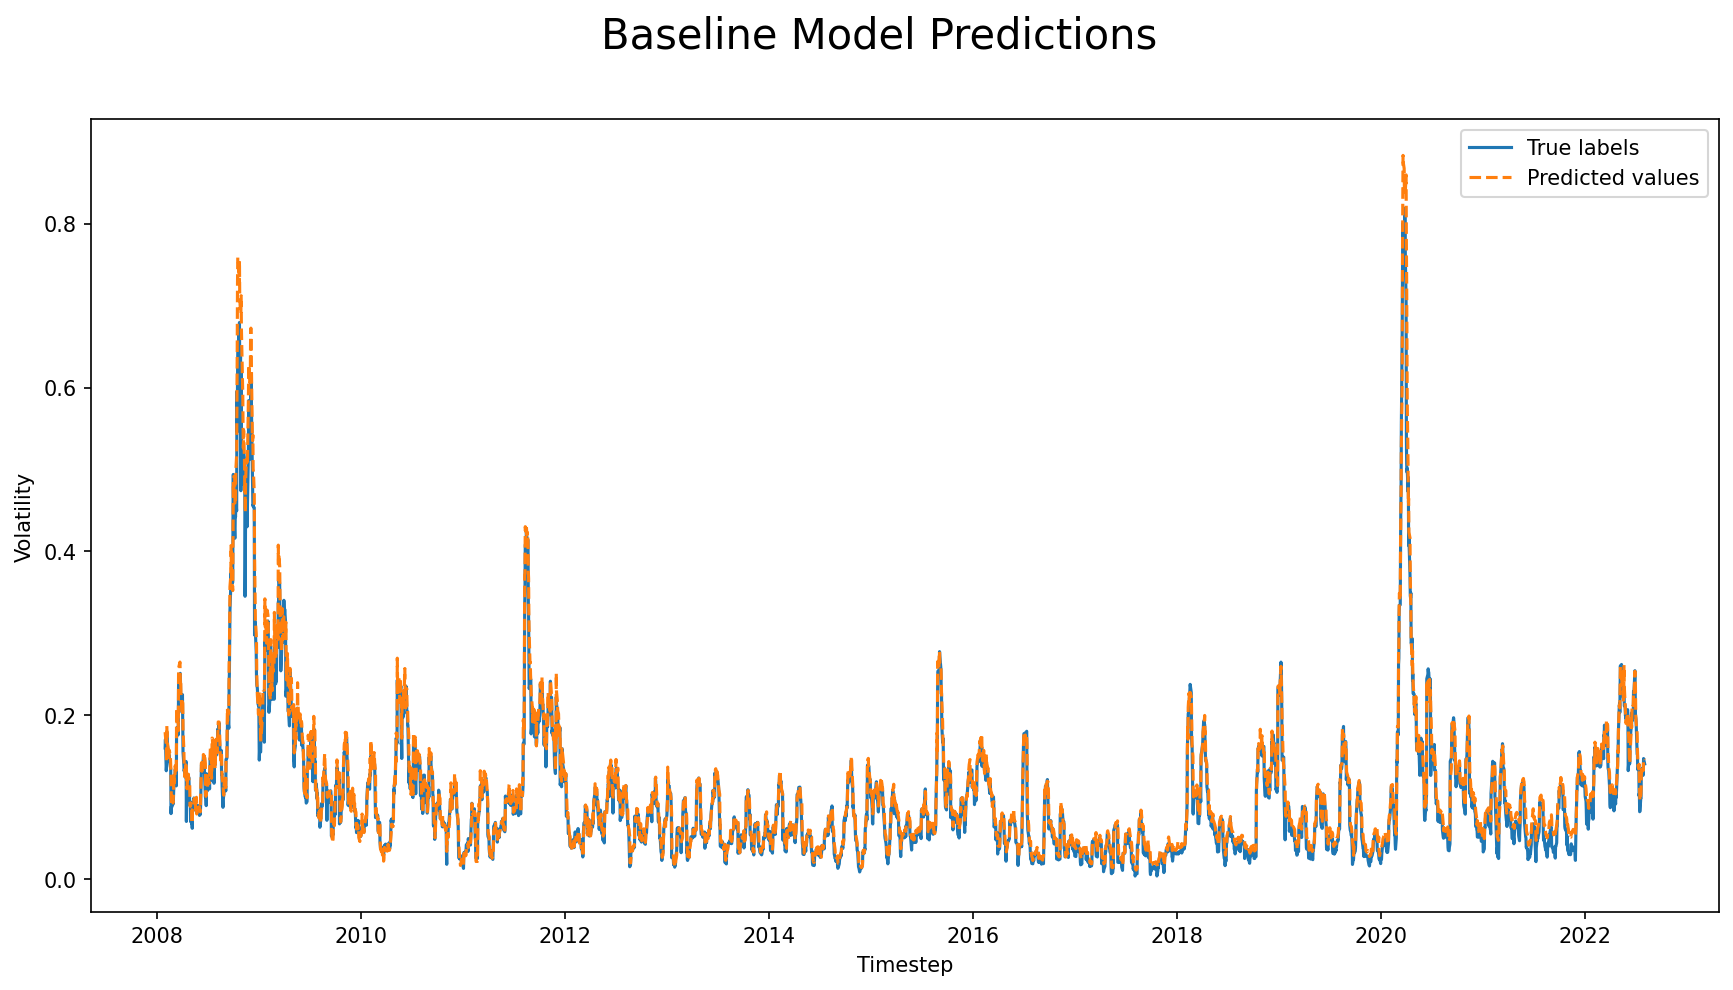

In [20]:
if BASELINE:
    # training loss plots
    history_comp = history['baseline']
    
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig1.suptitle("Accuracy of Baseline Model Training", fontsize=20)

    ax1[0].plot(history_comp['loss'], color='b', label="Training")
    ax1[0].plot(history_comp['val_loss'], color='r', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(history_comp['mse'], color='b', label="Training")
    ax1[1].plot(history_comp['val_mse'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('MSE')

    fig1.savefig(results_path + "loss-baseline.png")

    # prediction plot
    y_pred_comp = comp_model.predict(X_test)
    y_pred_comp = y_pred_comp.flatten()
    y_pred_plot = pd.Series(y_pred_comp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Baseline Model Predictions", fontsize=20)
    
    ax2.plot(y_test_plot, label='True labels')
    ax2.plot(y_pred_plot, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')
    
    plt.show()
    fig2.savefig(results_path + "predictions-baseline.png")

In [21]:
if BASELINE:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_comp)
    rmse = compute_rmse(y_test.flatten(), y_pred_comp)
    mape = compute_mape(y_test.flatten(), y_pred_comp)
    r_squared = r2_score(y_test.flatten(), y_pred_comp)

    print("Accuracy metrics for baseline model:")
    print(f"* mae = {mae:.5f}")
    print(f"* rmse = {rmse:.5f}")
    print(f"* r^2 = {r_squared:.5f}")
    print(f"* mape = {mape:.5f}%")

Accuracy metrics for baseline model:
* mae = 0.00934
* rmse = 0.01707
* r^2 = 0.96559
* mape = 13.72693%


### Mixed-precision Training

In [19]:
if LOW_BIT_TRAINING:
    # set tensorflow to use mixed precision
    policy_mp = mixed_precision.Policy(MIXED_PRECISION)
    mixed_precision.set_global_policy(policy_mp)

    print(f'Compute dtype: {policy_mp.compute_dtype}')
    print(f'Variable dtype: {policy_mp.variable_dtype}')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5
Compute dtype: float16
Variable dtype: float32


In [20]:
if LOW_BIT_TRAINING:
    # use same model as during baseline process
    mp_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, input_shape=(X_train.shape[1:]), activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])
    
    # compile and train comparison model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    mp_model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    # train and evaluate
    start_mp = time()
    hist = mp_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    total_time_mp = time() - start_mp
    history_mp = hist.history

Epoch 1/100
92/92 [==============================] - 7s 31ms/step - loss: 0.0274 - mse: 0.0018 - val_loss: 0.0214 - val_mse: 0.0013
Epoch 2/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0195 - mse: 9.4792e-04 - val_loss: 0.0192 - val_mse: 0.0010
Epoch 3/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0186 - mse: 8.6449e-04 - val_loss: 0.0187 - val_mse: 9.7260e-04
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0180 - mse: 8.0511e-04 - val_loss: 0.0179 - val_mse: 8.9160e-04
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0171 - mse: 7.3667e-04 - val_loss: 0.0178 - val_mse: 7.8559e-04
Epoch 6/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0163 - mse: 6.0490e-04 - val_loss: 0.0159 - val_mse: 6.1893e-04
Epoch 7/100
92/92 [==============================] - 2s 19ms/step - loss: 0.0148 - mse: 4.9448e-04 - val_loss: 0.0137 - val_mse: 5.0923e-04
Epoch 8/100
92/92 [=============

In [21]:
if LOW_BIT_TRAINING:
    # Comparison model architecture
    mp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 16)            1536      
                                                                 
 lstm_4 (LSTM)               (None, 10, 16)            2112      
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


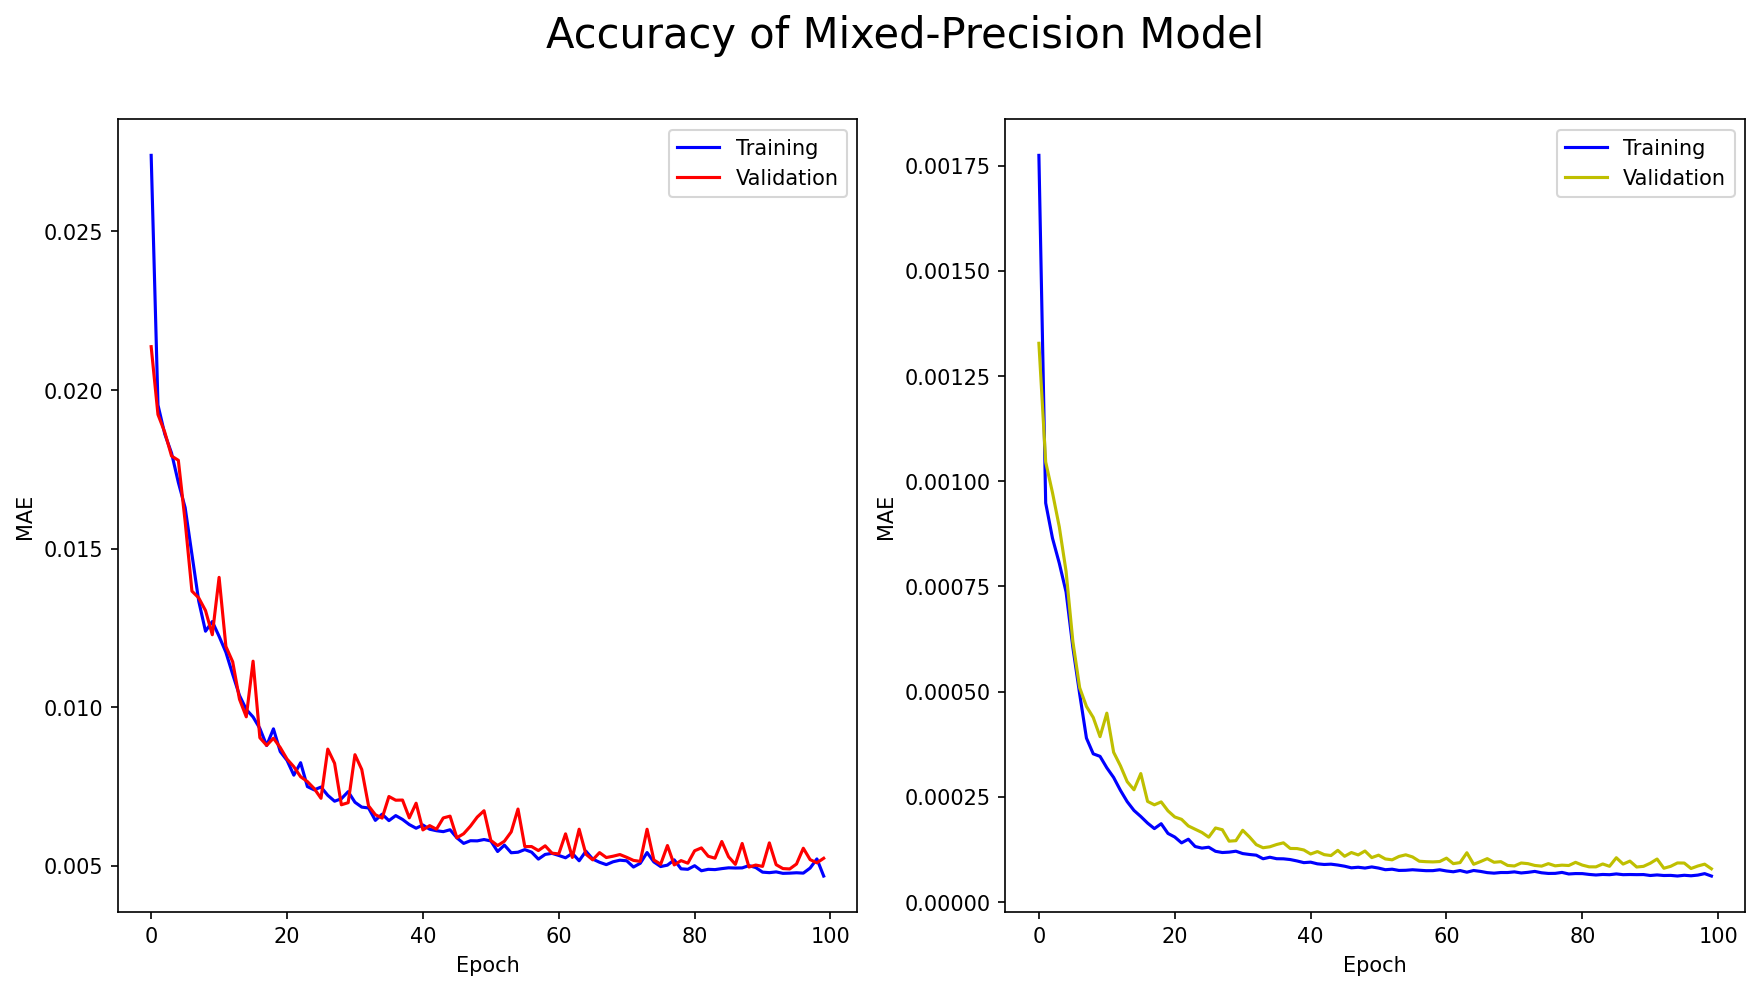

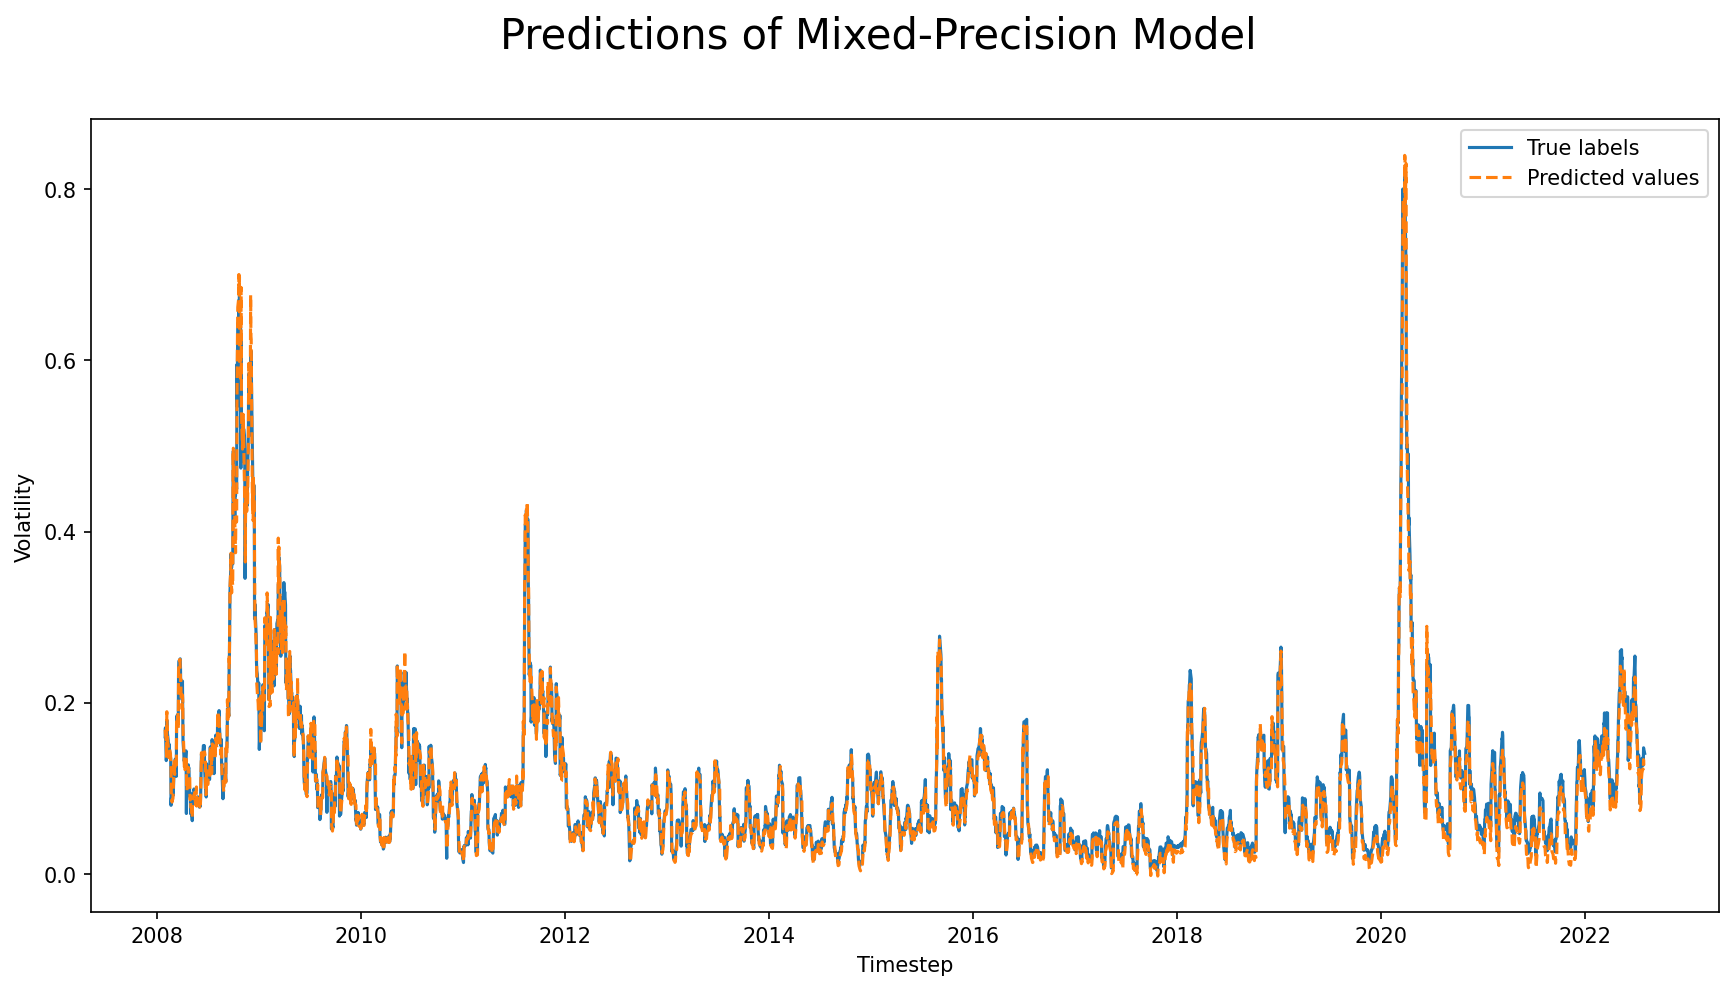

In [22]:
if LOW_BIT_TRAINING:
    # training loss plots
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig1.suptitle("Accuracy of Mixed-Precision Model", fontsize=20)

    ax1[0].plot(history_mp['loss'], color='b', label="Training")
    ax1[0].plot(history_mp['val_loss'], color='r', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(history_mp['mse'], color='b', label="Training")
    ax1[1].plot(history_mp['val_mse'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('MAE')

    fig1.savefig(results_path + "loss-mixedprecision.png")

    # prediction plot
    y_pred_mp = mp_model.predict(X_test)
    y_pred_mp = y_pred_mp.flatten()
    y_pred_plot = pd.Series(y_pred_mp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Predictions of Mixed-Precision Model", fontsize=20)

    ax2.plot(y_test_plot, label='True labels')
    ax2.plot(y_pred_plot, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig2.savefig(results_path + "predictions-mixedprecision.png")

In [23]:
if LOW_BIT_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_mp)
    rmse = compute_rmse(y_test.flatten(), y_pred_mp)
    mape = compute_mape(y_test.flatten(), y_pred_mp)
    r_squared = r2_score(y_test.flatten(), y_pred_mp)

    print("Accuracy metrics for mixed-precision model:")
    print(f"\t mae = {mae:.5f}")
    print(f"\t rmse = {rmse:.5f}")
    print(f"\t r^2 = {r_squared:.5f}")
    print(f"\t mape = {mape:.5f}%")

    print("\nEfficiency metrics for mixed-precision model:")
    print(f"\t training time = {total_time_mp:.2f}s")

Accuracy metrics for mixed-precision model:
	 mae = 0.00938
	 rmse = 0.01345
	 r^2 = 0.97864
	 mape = 13.26683%

Efficiency metrics for mixed-precision model:
	 training time = 189.03s


### Supervised layer-wise training

In [24]:
# train the initial model
def base_model(X, y):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


# add a layer to the model and train it
def progress_layers(model, X, y, history, ret_seq):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer (if final LSTM layer, do not return sequences)
    model.add(LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh'))
    model.add(output)

    # retrain newest layer (+ output layer)
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])
    history['mse'].extend(hist.history['mse'])
    history['val_mse'].extend(hist.history['val_mse'])

    return model, history, _timer


# final tuning over full model
def final_training(model, X, y):
    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start
    
    return model, history.history, _timer

In [25]:
if PROGRESSIVE_TRAINING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


In [26]:
if PROGRESSIVE_TRAINING:
    # initial model
    sup_model, history_sup_pretraining, pretrain_time_sup = base_model(X_train, y_train)
    test_loss_1, test_acc_1 = sup_model.evaluate(X_test, y_test)

    # add 2nd LSTM layer & pre-train
    sup_model, history_sup_pretraining, timer = progress_layers(sup_model, X_train, y_train, history_sup_pretraining, ret_seq=True)
    pretrain_time_sup += timer
    test_loss_2, test_acc_2 = sup_model.evaluate(X_test, y_test)

    # add 3rd LSTM layer & pre-train
    sup_model, history_sup_pretraining, timer = progress_layers(sup_model, X_train, y_train, history_sup_pretraining, ret_seq=False)
    pretrain_time_sup += timer
    test_loss_2, test_acc_2 = sup_model.evaluate(X_test, y_test)

    # tune the complete model
    sup_model, history_sup_tuning, tuning_time_sup = final_training(sup_model, X_train, y_train)

Epoch 1/20
92/92 [==============================] - 4s 22ms/step - loss: 0.0283 - mse: 0.0019 - val_loss: 0.0245 - val_mse: 0.0015
Epoch 2/20
92/92 [==============================] - 1s 13ms/step - loss: 0.0212 - mse: 0.0012 - val_loss: 0.0209 - val_mse: 0.0013
Epoch 3/20
92/92 [==============================] - 1s 13ms/step - loss: 0.0200 - mse: 0.0011 - val_loss: 0.0205 - val_mse: 0.0012
Epoch 4/20
92/92 [==============================] - 2s 18ms/step - loss: 0.0196 - mse: 0.0010 - val_loss: 0.0200 - val_mse: 0.0012
Epoch 5/20
92/92 [==============================] - 1s 13ms/step - loss: 0.0194 - mse: 9.9935e-04 - val_loss: 0.0196 - val_mse: 0.0012
Epoch 6/20
92/92 [==============================] - 2s 18ms/step - loss: 0.0190 - mse: 9.6709e-04 - val_loss: 0.0193 - val_mse: 0.0011
Epoch 7/20
92/92 [==============================] - 2s 18ms/step - loss: 0.0189 - mse: 9.6160e-04 - val_loss: 0.0191 - val_mse: 0.0011
Epoch 8/20
92/92 [==============================] - 1s 13ms/step - loss

In [27]:
if PROGRESSIVE_TRAINING:
    # Supervised model architecture
    sup_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 16)            1536      
                                                                 
 lstm_7 (LSTM)               (None, 10, 16)            2112      
                                                                 
 lstm_8 (LSTM)               (None, 16)                2112      
                                                                 
 dense_2 (Dense)             multiple                  17        
                                                                 
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


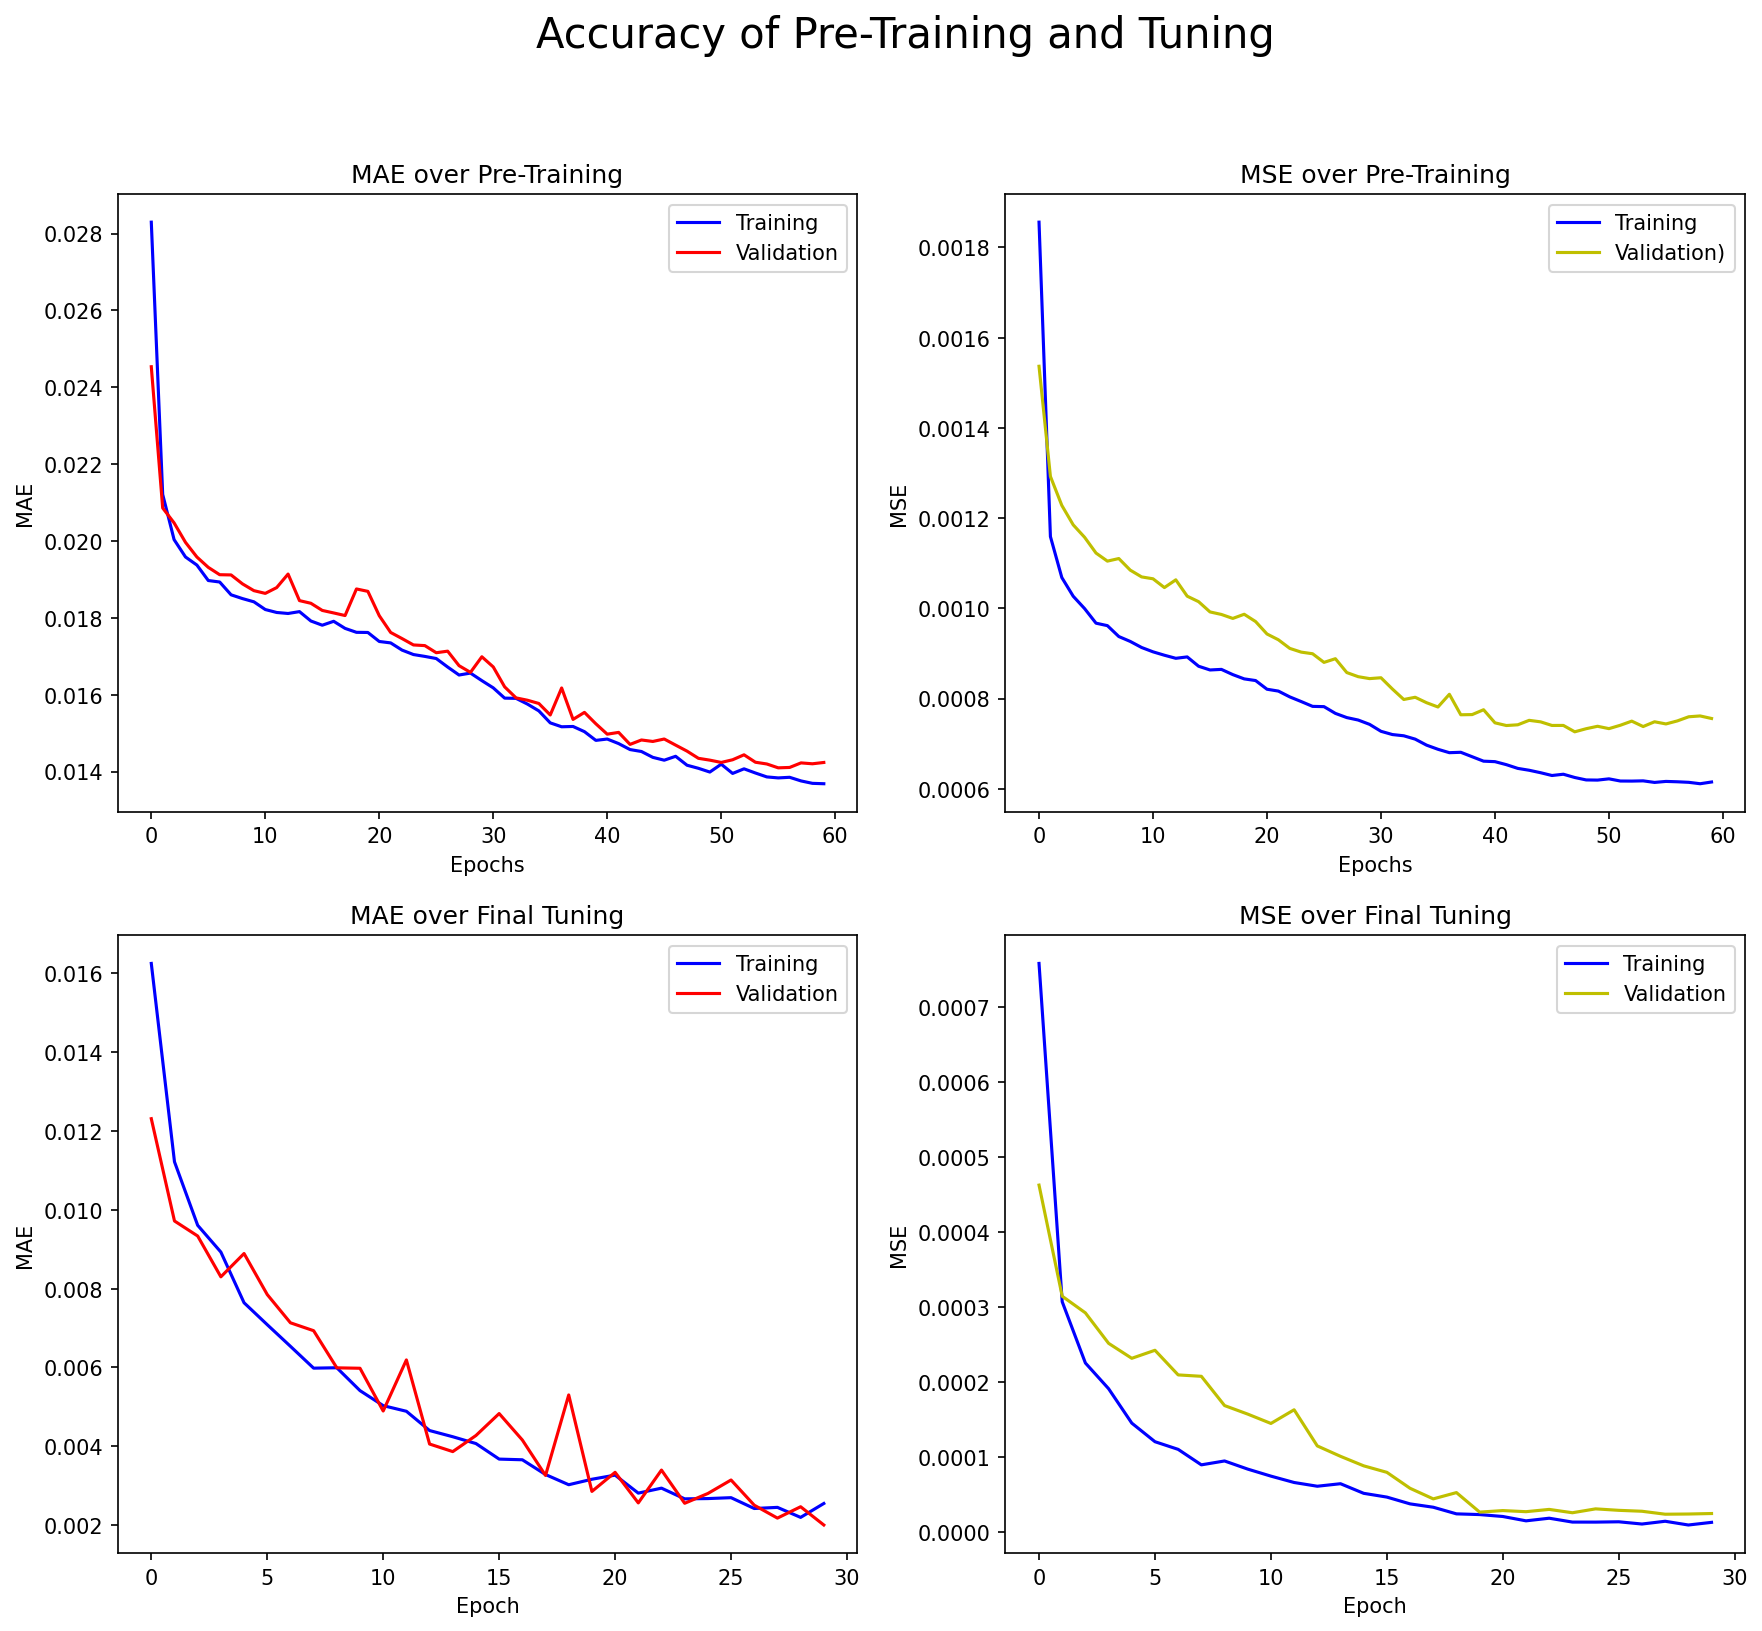

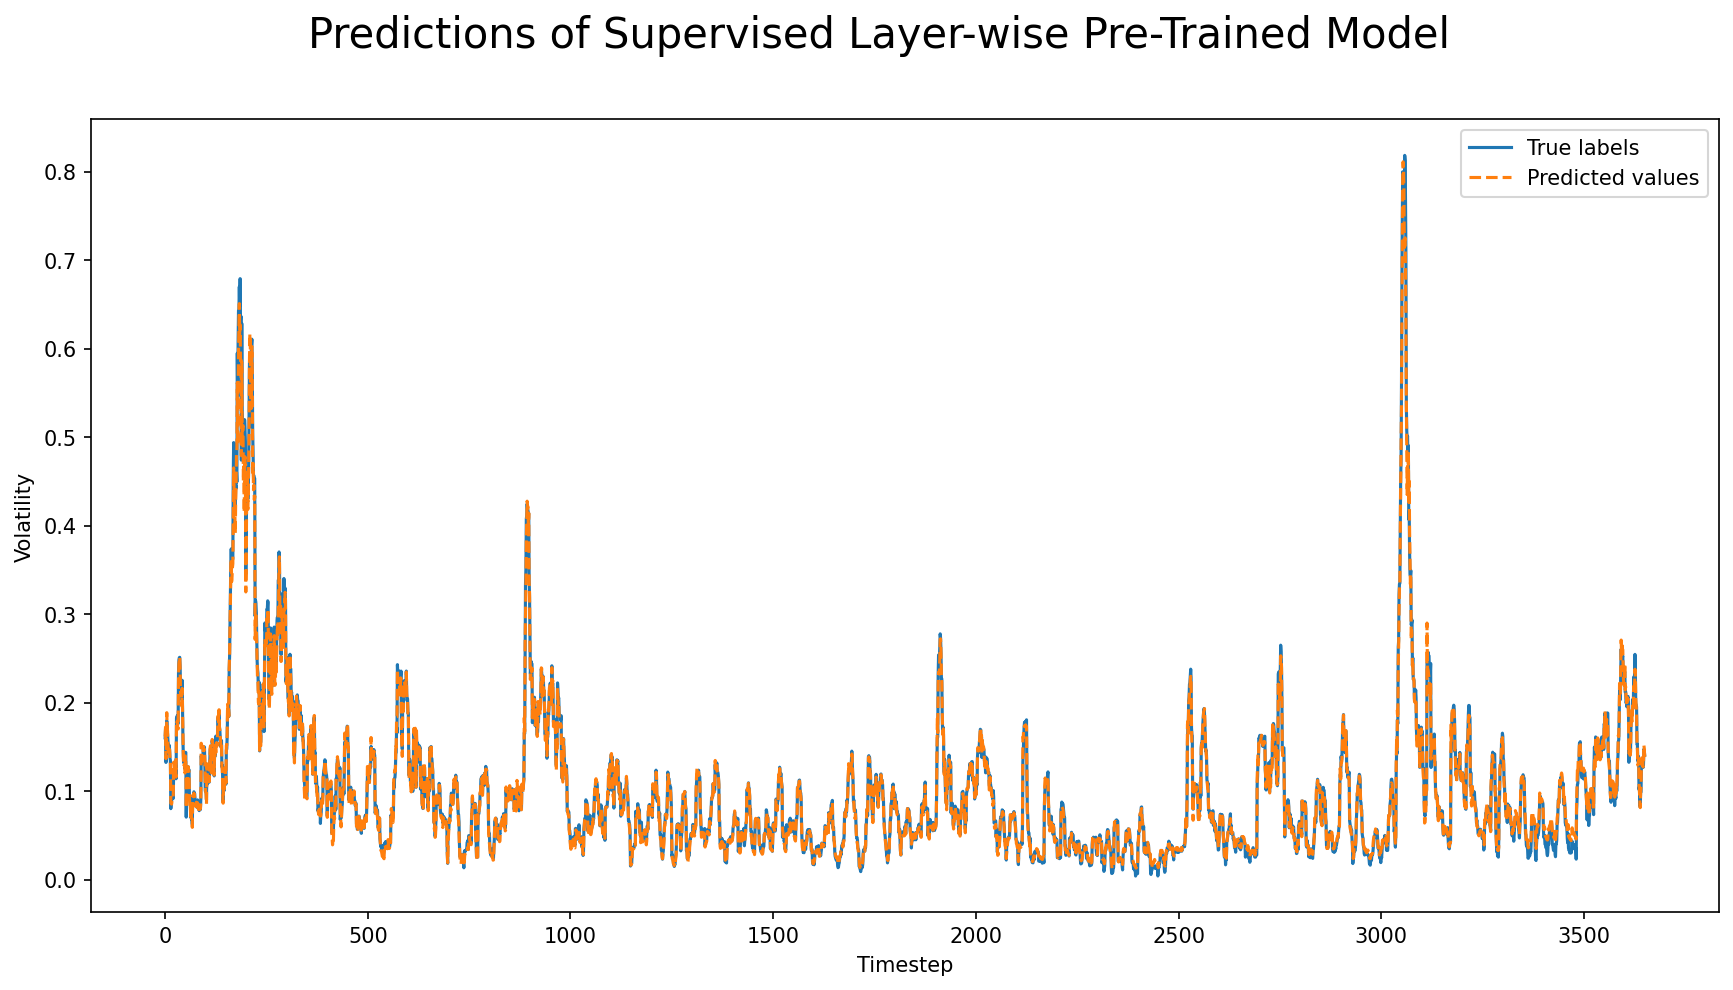

In [28]:
if PROGRESSIVE_TRAINING:
    # pretraining loss plots
    fig1, ax1 = plt.subplots(2, 2, figsize=(14, 12), dpi=150)
    fig1.suptitle("Accuracy of Pre-Training and Tuning", fontsize=20)

    ax1[0, 0].plot(history_sup_pretraining['loss'], color='b', label="Training")
    ax1[0, 0].plot(history_sup_pretraining['val_loss'], color='r', label="Validation")
    ax1[0, 0].legend(loc=0)
    ax1[0, 0].set(title='MAE over Pre-Training', xlabel='Epochs', ylabel='MAE')

    ax1[0, 1].plot(history_sup_pretraining['mse'], color='b', label="Training")
    ax1[0, 1].plot(history_sup_pretraining['val_mse'], color='y', label="Validation)")
    ax1[0, 1].legend(loc=0)
    ax1[0, 1].set(title='MSE over Pre-Training', xlabel='Epochs', ylabel='MSE')

    # tuning loss plots
    ax1[1, 0].plot(history_sup_tuning['loss'], color='b', label="Training")
    ax1[1, 0].plot(history_sup_tuning['val_loss'], color='r', label="Validation")
    ax1[1, 0].legend(loc=0)
    ax1[1, 0].set(title='MAE over Final Tuning', xlabel='Epoch', ylabel='MAE')

    ax1[1, 1].plot(history_sup_tuning['mse'], color='b', label="Training")
    ax1[1, 1].plot(history_sup_tuning['val_mse'], color='y', label="Validation")
    ax1[1, 1].legend(loc=0)
    ax1[1, 1].set(title='MSE over Final Tuning', xlabel='Epoch', ylabel='MSE')

    fig1.savefig(results_path + "loss-suplayerwise.png")

    # prediction plot
    y_pred_sup = sup_model.predict(X_test)
    y_pred_sup = y_pred_sup.flatten()

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Predictions of Supervised Layer-wise Pre-Trained Model", fontsize=20)

    ax2.plot(y_test.flatten(), label='True labels')
    ax2.plot(y_pred_sup, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig2.savefig(results_path + "predictions-suplayerwise.png")

In [29]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_sup)
    rmse = compute_rmse(y_test.flatten(), y_pred_sup)
    mape = compute_mape(y_test.flatten(), y_pred_sup)
    r_squared = r2_score(y_test.flatten(), y_pred_sup)

    print("Accuracy metrics for supervised pre-trained model:")
    print(f"\t mae = {mae:.5f}")
    print(f"\t rmse = {rmse:.5f}")
    print(f"\t r^2 = {r_squared:.5f}")
    print(f"\t mape = {mape:.5f}%")

    print("\nEfficiency metrics for supervised pre-trained model:")
    print(f"\t pre-training time = {pretrain_time_sup:.2f}s")
    print(f"\t final tuning time = {tuning_time_sup:.2f}s")
    print(f"\t total training time = {pretrain_time_sup + tuning_time_sup:.2f}s")


Accuracy metrics for supervised pre-trained model:
	 mae = 0.00439
	 rmse = 0.00756
	 r^2 = 0.99324
	 mape = 6.49784%

Efficiency metrics for supervised pre-trained model:
	 pre-training time = 124.31s
	 final tuning time = 56.28s
	 total training time = 180.59s


### Unsupervised layer-wise training

In [30]:
# initial autoencoder model
def base_autoencoder(X):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True, input_shape=(X.shape[1:])),
        TimeDistributed(Dense(X.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


# adding layers to autoencoder model
def add_autoencoder(model, X, history, ret_seq):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh'))

    # readd output layer (new output layer required if on final LSTM layer)
    if ret_seq:
        model.add(output)
    else:
        model.add(Dense(1, activation='linear'))

    # train new autoencoder layer
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # collect metrics
    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])

    return model, history, _timer


# conversion of model into a regressor, and final tuning rounds
def build_final_model(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(Dense(1, activation='linear'))
    
    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, history.history, _timer

In [31]:
if PROGRESSIVE_TRAINING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


In [32]:
if PROGRESSIVE_TRAINING:
    # train initial model
    encoder, enc_history, total_enc_time = base_autoencoder(X_train)

    # add 2nd LSTM layer & pre-train
    encoder, enc_history, timer = add_autoencoder(encoder, X_train, enc_history, ret_seq=True)
    total_enc_time += timer

    # add 3rd LSTM layer & pre-train
    encoder, enc_history, timer = add_autoencoder(encoder, X_train, enc_history, ret_seq=False)
    total_enc_time += timer

    # conduct final tuning with regression output layer
    regressor, reg_history, total_reg_time = build_final_model(encoder, X_train, y_train)

Epoch 1/20
92/92 [==============================] - 3s 21ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 2/20
92/92 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/20
92/92 [==============================] - 2s 17ms/step - loss: 8.5656e-04 - val_loss: 7.2614e-04
Epoch 4/20
92/92 [==============================] - 2s 17ms/step - loss: 5.8730e-04 - val_loss: 5.0515e-04
Epoch 5/20
92/92 [==============================] - 1s 11ms/step - loss: 4.0886e-04 - val_loss: 3.5404e-04
Epoch 6/20
92/92 [==============================] - 1s 11ms/step - loss: 2.9108e-04 - val_loss: 2.5868e-04
Epoch 7/20
92/92 [==============================] - 2s 17ms/step - loss: 2.1295e-04 - val_loss: 1.9473e-04
Epoch 8/20
92/92 [==============================] - 1s 11ms/step - loss: 1.5963e-04 - val_loss: 1.4895e-04
Epoch 9/20
92/92 [==============================] - 1s 11ms/step - loss: 1.2288e-04 - val_loss: 1.1701e-04
Epoch 10/20
92/92 [==============================] - 

In [33]:
if PROGRESSIVE_TRAINING:
    # Unsupervised model architecture
    regressor.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 16)            1536      
                                                                 
 lstm_10 (LSTM)              (None, 10, 16)            2112      
                                                                 
 lstm_11 (LSTM)              (None, 16)                2112      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


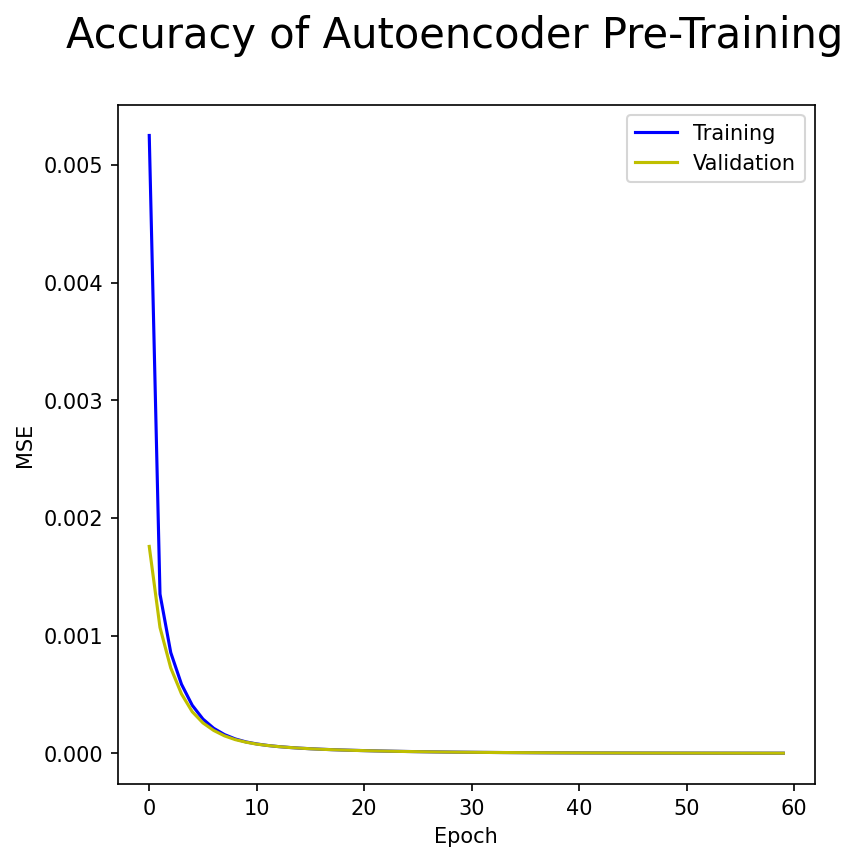

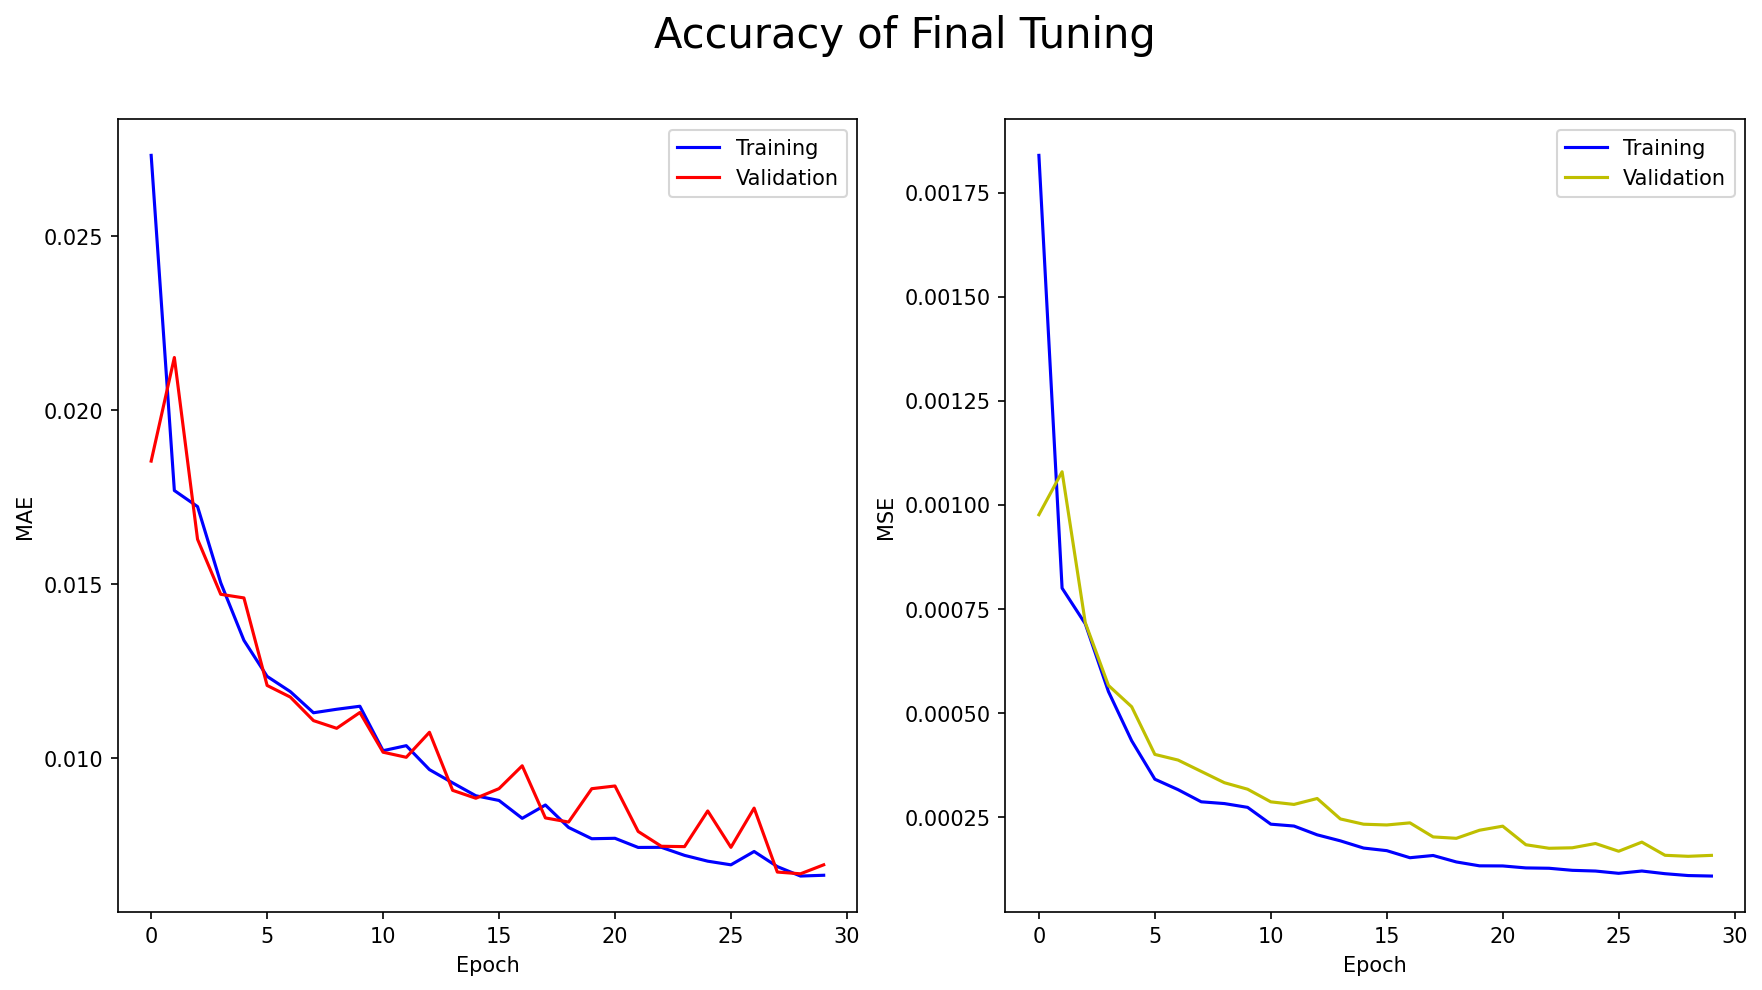

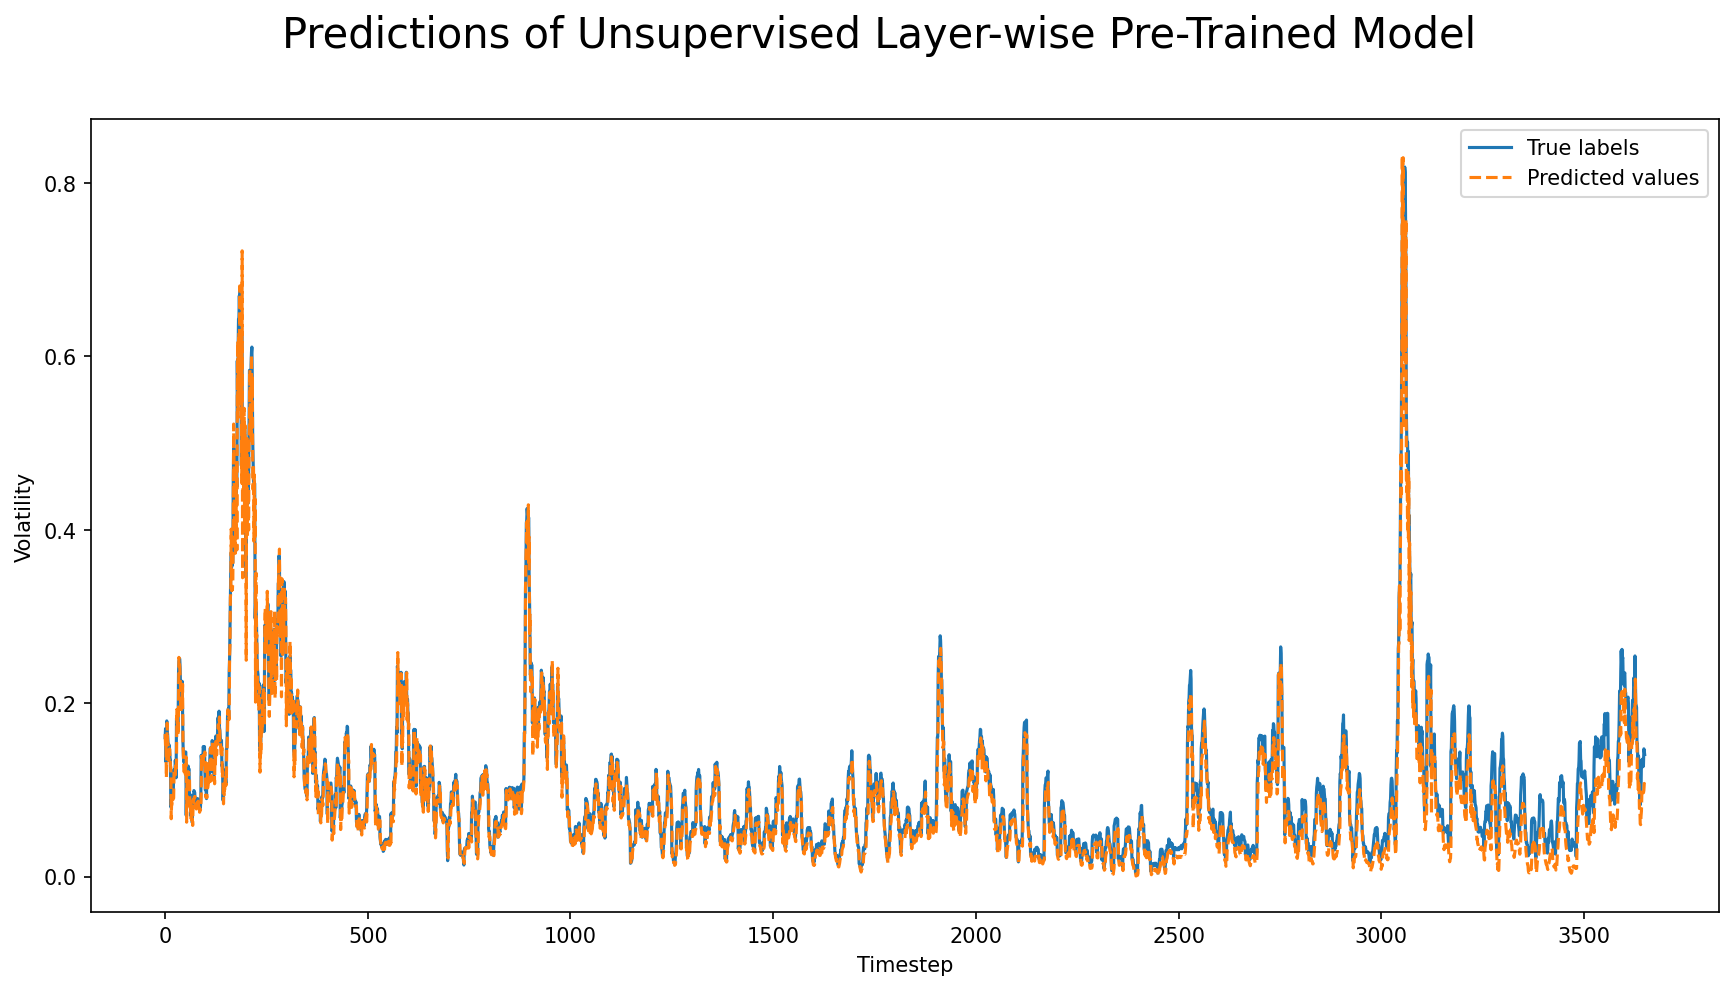

In [34]:
if PROGRESSIVE_TRAINING:
    # autoencoder loss plots
    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=150)
    fig1.suptitle("Accuracy of Autoencoder Pre-Training", fontsize=20)

    ax1.plot(enc_history['loss'], color='b', label="Training")
    ax1.plot(enc_history['val_loss'], color='y', label="Validation")
    ax1.legend(loc=0)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE')

    fig1.savefig(results_path + "loss-unsuplayerwise-encoder.png")

    # regressor loss plots
    fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig2.suptitle("Accuracy of Final Tuning", fontsize=20)

    ax2[0].plot(reg_history['loss'], color='b', label="Training")
    ax2[0].plot(reg_history['val_loss'], color='r', label="Validation")
    ax2[0].legend(loc=0)
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('MAE')

    ax2[1].plot(reg_history['mse'], color='b', label="Training")
    ax2[1].plot(reg_history['val_mse'], color='y', label="Validation")
    ax2[1].legend(loc=0)
    ax2[1].set_xlabel('Epoch')
    ax2[1].set_ylabel('MSE')

    fig2.savefig(results_path + "loss-unsuplayerwise-regressor.png")

    # prediction plot
    y_pred_unsup = regressor.predict(X_test)
    y_pred_unsup = y_pred_unsup.flatten()

    fig3, ax3 = plt.subplots(figsize=(14, 7), dpi=150)
    fig3.suptitle("Predictions of Unsupervised Layer-wise Pre-Trained Model", fontsize=20)

    ax3.plot(y_test.flatten(), label='True labels')
    ax3.plot(y_pred_unsup, linestyle='--', label='Predicted values')
    ax3.legend(loc=0)
    ax3.set_xlabel('Timestep')
    ax3.set_ylabel('Volatility')

    plt.show()
    fig3.savefig(results_path + "predictions-unsuplayerwise.png")

In [35]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_unsup)
    rmse = compute_rmse(y_test.flatten(), y_pred_unsup)
    mape = compute_mape(y_test.flatten(), y_pred_unsup)
    r_squared = r2_score(y_test.flatten(), y_pred_unsup)

    print("Accuracy metrics for unsupervised pre-trained model:")
    print(f"\t mae = {mae:.5f}")
    print(f"\t rmse = {rmse:.5f}")
    print(f"\t r^2 = {r_squared:.5f}")
    print(f"\t mape = {mape:.5f}%")

    print("\nEfficiency metrics for unsupervised pre-trained model:")
    print(f"\t pre-training time = {total_enc_time:.2f}s")
    print(f"\t final tuning time = {total_reg_time:.2f}s")
    print(f"\t total training time = {total_enc_time + total_reg_time:.2f}s")

Accuracy metrics for unsupervised pre-trained model:
	 mae = 0.01556
	 rmse = 0.02308
	 r^2 = 0.93711
	 mape = 19.23244%

Efficiency metrics for unsupervised pre-trained model:
	 pre-training time = 109.48s
	 final tuning time = 56.76s
	 total training time = 166.24s


### Active Learning

In [36]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)
    distance_vector = np.linalg.norm(np.linalg.norm(X - centroid, axis=2), axis=1)

    initial_instance_index = np.argmin(distance_vector)
    initial_X = X[initial_instance_index]
    initial_y = y[initial_instance_index]

    new_indices = np.setdiff1d(range(X.shape[0]), [8306])
    X = X[new_indices]
    y = y[new_indices]

    # compute euclidean distance of all instances to initial instance
    distance_matrix = np.linalg.norm(np.linalg.norm(X - initial_X, axis=2), axis=1)

    # select instances with largest distance (to boost diversity)
    train_indices = np.argpartition(distance_matrix, -k)[-k:]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.flatten()
    _y_t = y_t.flatten()
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [37]:
if ACTIVE_LEARNING:
    # ensure tensorflow is using high precision (i.e. not in low-bit training mode)
    policy_hp = mixed_precision.Policy(HIGH_PRECISION)
    mixed_precision.set_global_policy(policy_hp)

    print(f'Compute dtype: {policy_hp.compute_dtype}')
    print(f'Variable dtype: {policy_hp.variable_dtype}')

Compute dtype: float32
Variable dtype: float32


In [38]:
if ACTIVE_LEARNING:
    # build RNN/LSTM architecture
    lstm_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    adam_opt = Adam(learning_rate=0.001, decay=1e-5)
    lstm_model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [39]:
if ACTIVE_LEARNING:
    # active learning training
    histories = {}
    total_time_al = 0

    # initial training over seed dataset
    _start = time()
    X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
    history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)
    total_time_al += time() - _start

    # store metrics
    histories.update({
        'loss': [np.min(history.history['loss'])],
        'mse': [np.min(history.history['mse'])],
        'val_loss': [np.min(history.history['val_loss'])],
        'val_mse': [np.min(history.history['val_mse'])]
    })
    
    # iteratively train model
    for it in range(AL_ITERATIONS):
        print(f"Iteration {it+1}/{AL_ITERATIONS}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
        if X_val.shape[0] >= AL_SAMPLE:
            _start = time()

            # use GSy method to select samples to add to the training pool
            X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

            # train model over pool
            history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
            total_time_al += time() - _start
            
            # store metrics
            histories['loss'].append(np.min(history.history['loss']))
            histories['mse'].append(np.min(history.history['mse']))
            histories['val_loss'].append(np.min(history.history['val_loss']))
            histories['val_mse'].append(np.min(history.history['val_mse']))
        else:
            break

Iteration 1/100; pool = 100, val = 14499
2/2 [==============================] - 0s 66ms/step - loss: 0.1219 - mse: 0.0158 - val_loss: 0.0861 - val_mse: 0.0373
Iteration 2/100; pool = 200, val = 14399
2/2 [==============================] - 0s 72ms/step - loss: 0.0856 - mse: 0.0084 - val_loss: 0.0661 - val_mse: 0.0230
Iteration 3/100; pool = 300, val = 14299
3/3 [==============================] - 0s 51ms/step - loss: 0.0594 - mse: 0.0130 - val_loss: 0.0706 - val_mse: 0.0158
Iteration 4/100; pool = 400, val = 14199
4/4 [==============================] - 0s 33ms/step - loss: 0.0895 - mse: 0.0447 - val_loss: 0.0891 - val_mse: 0.0106
Iteration 5/100; pool = 500, val = 14099
4/4 [==============================] - 0s 35ms/step - loss: 0.1088 - mse: 0.0381 - val_loss: 0.0836 - val_mse: 0.0091
Iteration 6/100; pool = 600, val = 13999
5/5 [==============================] - 0s 31ms/step - loss: 0.0975 - mse: 0.0334 - val_loss: 0.0564 - val_mse: 0.0049
Iteration 7/100; pool = 700, val = 13899
5/5 [

In [40]:
if ACTIVE_LEARNING:
    lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 10, 16)            1536      
                                                                 
 lstm_13 (LSTM)              (None, 10, 16)            2112      
                                                                 
 lstm_14 (LSTM)              (None, 16)                2112      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,777
Trainable params: 5,777
Non-trainable params: 0
_________________________________________________________________


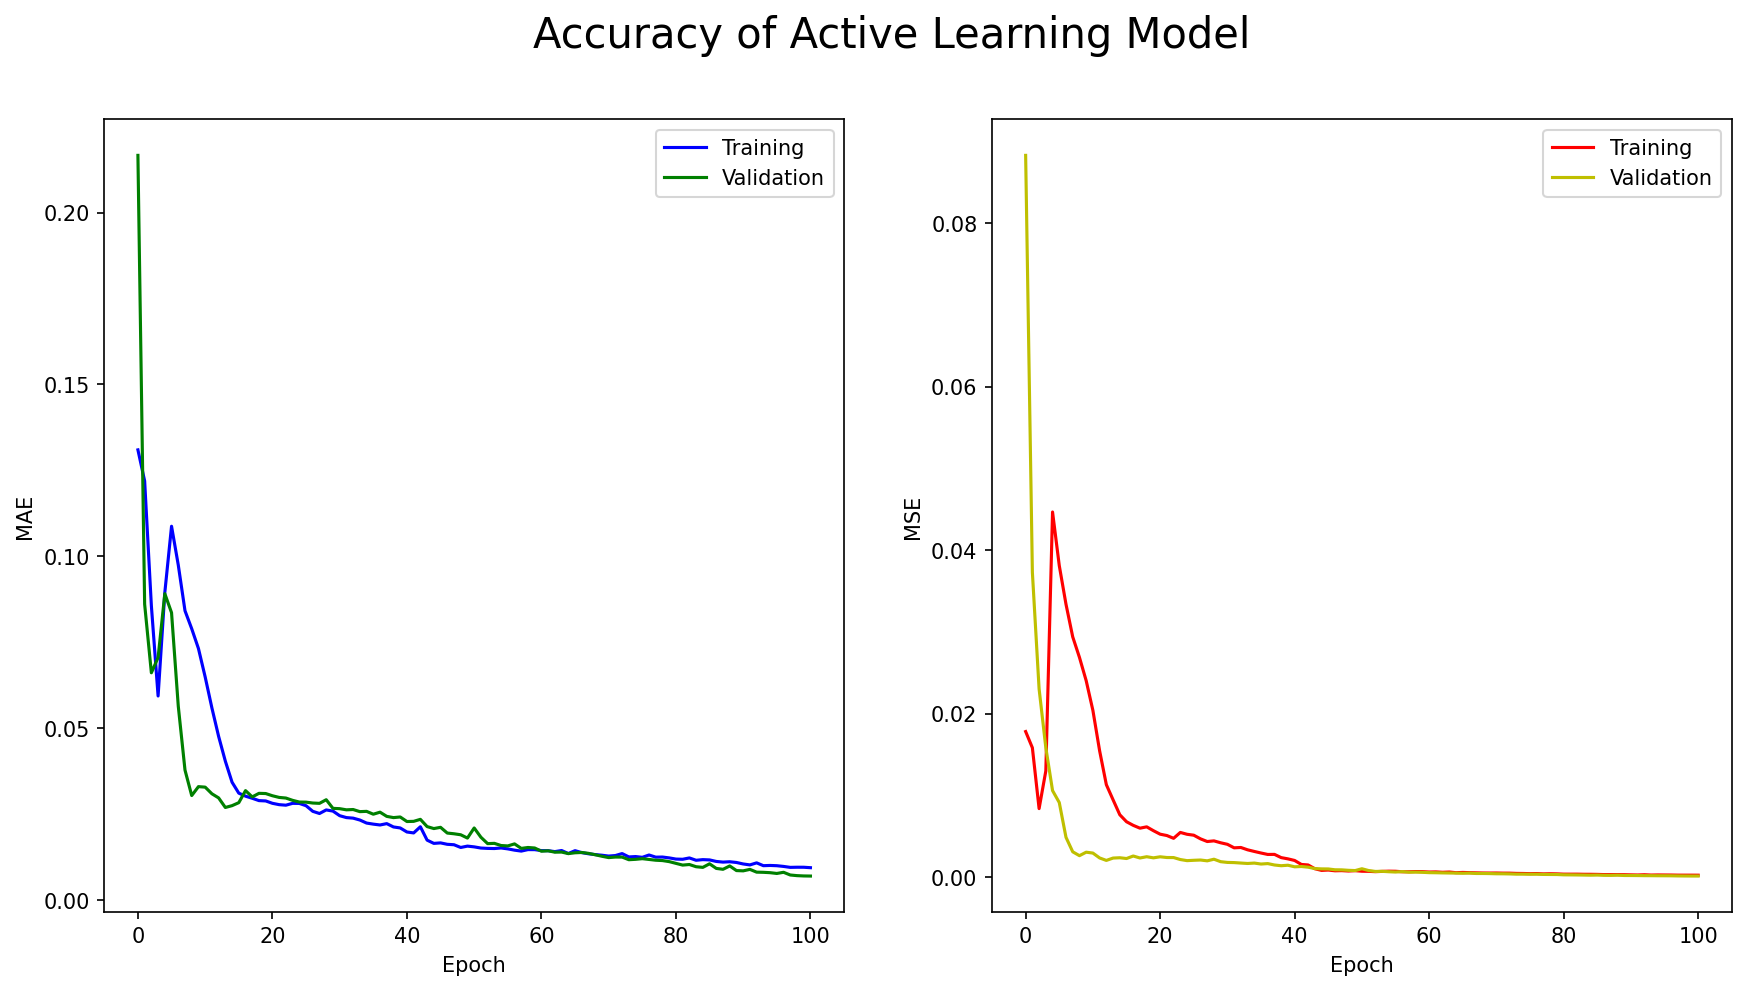

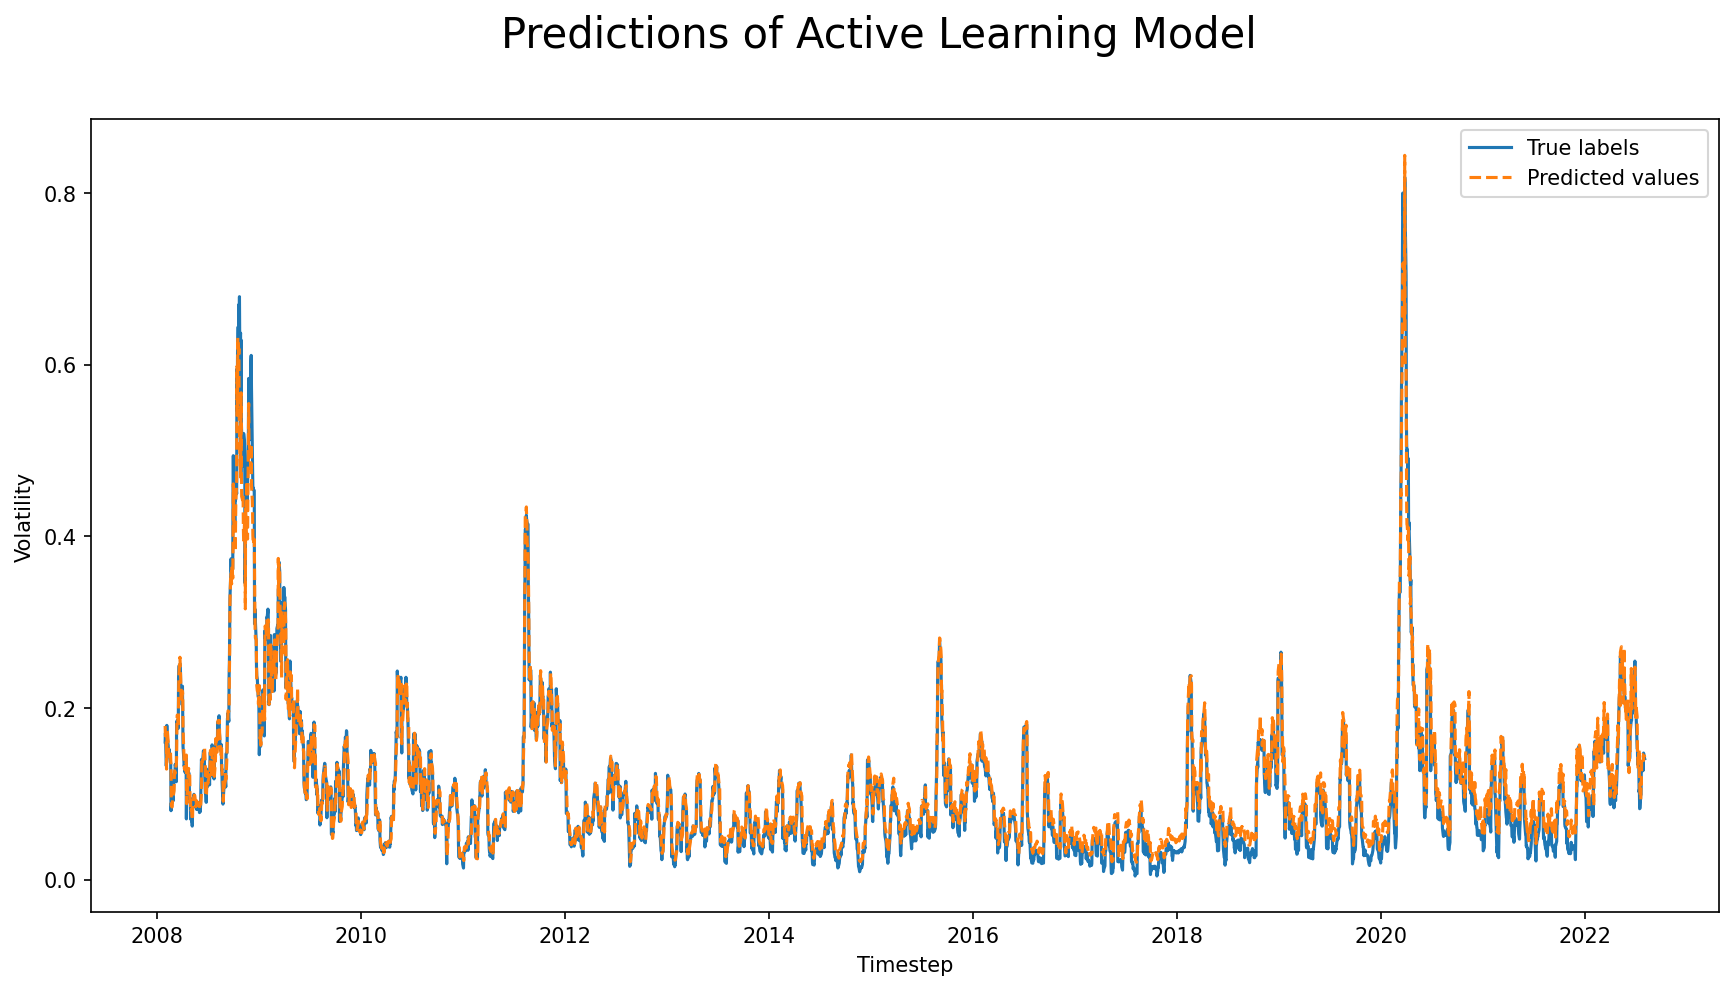

In [41]:
if ACTIVE_LEARNING:
    # training loss plot
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig1.suptitle("Accuracy of Active Learning Model", fontsize=20)

    ax1[0].plot(histories['loss'], color='b', label="Training")
    ax1[0].plot(histories['val_loss'], color='g', label="Validation")
    ax1[0].legend(loc=0)
    ax1[0].set_xlabel('Epoch')
    ax1[0].set_ylabel('MAE')

    ax1[1].plot(histories['mse'], color='r', label="Training")
    ax1[1].plot(histories['val_mse'], color='y', label="Validation")
    ax1[1].legend(loc=0)
    ax1[1].set_xlabel('Epoch')
    ax1[1].set_ylabel('MSE')

    fig1.savefig(results_path + "loss-active.png")

    # prediction plot
    y_pred_al = lstm_model.predict(X_test)
    y_pred_al = y_pred_al.flatten()
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Predictions of Active Learning Model", fontsize=20)

    y_pred_plot = pd.Series(y_pred_al, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    ax2.plot(y_test_plot, label='True labels')
    ax2.plot(y_pred_plot, linestyle='--', label='Predicted values')
    ax2.legend(loc=0)
    ax2.set_xlabel('Timestep')
    ax2.set_ylabel('Volatility')

    plt.show()
    fig2.savefig(results_path + "predictions-active.png")

In [42]:
if ACTIVE_LEARNING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_al)
    rmse = compute_rmse(y_test.flatten(), y_pred_al)
    mape = compute_mape(y_test.flatten(), y_pred_al)
    r_squared = r2_score(y_test.flatten(), y_pred_al)

    print("Accuracy metrics for active learning model:")
    print(f"\t mae = {mae:.5f}")
    print(f"\t rmse = {rmse:.5f}")
    print(f"\t r^2 = {r_squared:.5f}")
    print(f"\t mape = {mape:.5f}%")

    print("\nEfficiency metrics for active learning model:")
    print(f"\t training time = {total_time_al:.2f}s")
    print(f"\t final pool size = {X_pool.shape[0]} / {X_train.shape[0]} = {(X_pool.shape[0] / X_train.shape[0]) * 100:.2f}%")
    print(f"\t final validation set size = {X_val.shape[0]} / {X_train.shape[0]} = {(X_val.shape[0] / X_train.shape[0]) * 100:.2f}%")

Accuracy metrics for active learning model:
	 mae = 0.01294
	 rmse = 0.01898
	 r^2 = 0.95745
	 mape = 22.04889%

Efficiency metrics for active learning model:
	 training time = 183.94s
	 final pool size = 10100 / 14600 = 69.18%
	 final validation set size = 4499 / 14600 = 30.82%
